In [29]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:
# This is the file of all dyfi quake data, with the times corrected.
# In this case, OK means Okay, not Oklahoma
df = pd.read_csv("./dyfi_OK.csv")

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273499 entries, 0 to 273498
Data columns (total 19 columns):
id               273499 non-null object
cdi_Latitude     273499 non-null float64
cdi_Longitude    273499 non-null float64
city             273499 non-null object
state            270854 non-null object
zip_code         273499 non-null object
is_suspect       273499 non-null int64
responses        273499 non-null int64
is_epi_dist      273499 non-null int64
distance         273499 non-null float64
cdi              273499 non-null float64
mmi              149235 non-null float64
mag              273499 non-null float64
mag_type         273499 non-null object
depth            273499 non-null float64
q_lat            273499 non-null float64
q_long           273499 non-null float64
q_time           273499 non-null object
is_OK            273499 non-null float64
dtypes: float64(10), int64(3), object(6)
memory usage: 39.6+ MB


In [32]:
df['id'].unique().size

7287

In [33]:
print df[df['responses'] >= 5].shape
print df[df['responses'] >= 5]['id'].unique().size

(85236, 19)
4425


In [34]:
print df[(df['responses'] >= 5) & (df['mmi'].notnull())].shape
print df[(df['responses'] >= 5) & (df['mmi'].notnull())]['id'].unique().size


(55892, 19)
1206


In [35]:
df.head()

,id,cdi_Latitude,cdi_Longitude,city,state,zip_code,is_suspect,responses,is_epi_dist,distance,cdi,mmi,mag,mag_type,depth,q_lat,q_long,q_time,is_OK
0,usp000j7ae,40.4084,-80.1105,Carnegie,PA,15106,0,1,1,149.0,3.1,NaN,2.8,mblg,5.0,39.4,-81.27,2011-08-31 05:35:12.410,0.0
1,usp000j7ae,39.7874,-79.8074,Smithfield,PA,15478,0,1,1,132.0,2.5,NaN,2.8,mblg,5.0,39.4,-81.27,2011-08-31 05:35:12.410,0.0
2,usp000j7ae,40.3849,-76.4271,Lebanon,PA,17046,0,1,1,428.0,2.0,NaN,2.8,mblg,5.0,39.4,-81.27,2011-08-31 05:35:12.410,0.0
3,usp000j7ae,40.1759,-76.2938,Lititz,PA,17543,0,1,1,434.0,2.2,NaN,2.8,mblg,5.0,39.4,-81.27,2011-08-31 05:35:12.410,0.0
4,usp000j7ae,39.0850,-75.6238,Camden Wyoming,DE,19934,0,3,1,488.0,3.4,NaN,2.8,mblg,5.0,39.4,-81.27,2011-08-31 05:35:12.410,0.0


In [36]:
df.describe()

,cdi_Latitude,cdi_Longitude,is_suspect,responses,is_epi_dist,distance,cdi,mmi,mag,depth,q_lat,q_long,is_OK
count,273499.000000,273499.000000,273499.0,273499.000000,273499.000000,273499.000000,273499.000000,149235.000000,273499.000000,273499.000000,273499.000000,273499.000000,273499.000000
mean,36.822912,-107.255146,0.0,10.688284,0.649161,163.103434,2.509284,5.425524,4.116283,9.375953,36.700975,-107.289092,0.146022
std,3.632780,16.000967,0.0,34.237408,0.477233,199.660695,0.820388,1.438646,1.024487,6.627626,3.664022,15.867966,0.353129
min,-38.180000,-155.809800,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,2.500000,-2.730000,25.013000,-129.958200,0.000000
25%,33.994000,-118.843900,0.0,1.000000,0.000000,40.000000,2.000000,4.360000,3.300000,5.000000,34.030667,-118.926550,0.000000
50%,36.073800,-117.171300,0.0,2.000000,1.000000,96.000000,2.300000,5.400000,3.980000,7.968000,35.987000,-116.474667,0.000000
75%,38.524750,-95.574200,0.0,7.000000,1.000000,207.000000,3.000000,6.400000,4.700000,12.500000,37.914667,-96.788000,0.000000
max,64.946100,178.430000,0.0,5750.000000,1.000000,17591.000000,8.900000,9.500000,7.300000,76.200000,48.958333,-67.352000,1.000000


## Issues to investigate
   - The minimum quake depth is -2.73, whereas the average depth is 9.37, so there is some inconsistency in whether depths are entered in negative or positive numbers.  Since there are no other possibilities for a negative depth, the correction will be to convert all to the absolute value of depth, making the negatives positive  
   - 65% of distances from dyfi observation point to earthquake origin are given as epicentral (on the surface) distances, while remainder are given has hypocentral (to the subsurface point where the fault slippage occurred. If the quakes with hypocentral observational distance measurements are not very deep, this won't matter much, but if they are, a trigonometric conversion to the surface distance will be necessary.  
   - Latitude / Longitude anomalies
        - minumum quake latitude is 25 degrees north and minimum cdi observation point latitude is -38 degrees south.
        - maximum quake latitude is 49 degrees north and minimum cdi observation point latitude is 65 degrees north.
        - minumum quake longitude is -130 degrees west while minimum cdi observation point longitude is -156 degrees west.
        - maximum quake longitude is -67 degrees west while maximum cdi observation point longitude is 178 degrees east (somewhere in Russia ... )  
          
        - If these distant obervation points are for quakes of large magnitude, then they are likely accurate.  However, if they occur for quakes of low magnitude then they should be dropped.  A formula using distance and magnitude may be needed to evaluate the probable accuracy of the distant observations.  
        

In [142]:
# # Correct epicentral distance to hypocentral distance

# # The hypocenter of an earthquake is the location beneath the earth’s surface where the 
# # rupture of the fault begins. The epicenter of an earthquake is the location directly
# # above the hypocenter on the surface of the earth.

# # ISSUE:  Some distances are less than depth,  an impossibility if the distance is truly hypocentral
# # Perhaps the hypocentral vs epicentral distance reports are ambiguous ?

# corr_dist = []
# for i in range(len(df)):
# #     if i % 1000 == 0:
# #         print "Processing records", i, " to", i+1000

#     if not df.loc[i, 'is_epi_dist']:  # Leave hypocentral distances unchanged
#         corr_dist.append(df.loc[i,'distance'])
#     else:                           # convert epicentral distance to hypocentral distance
#         corrected_distance = np.sqrt((df.loc[i,'distance']**2 + df.loc[i,'depth']**2))
#         corr_dist.append(corrected_distance)
# #         print i, (df_dyfi.loc[i,'depth'], df_dyfi.loc[i,'distance'], corrected_distance)

# df['hypocentral_distance'] = corr_dist

In [37]:
# Initially, drop observations that are outside reasonable distances from quake events
print df.shape
df = df[df['cdi_Latitude'] >= 25]
df = df[df['cdi_Latitude'] <= 52]
df = df[df['cdi_Longitude'] >= -130]
df = df[df['cdi_Longitude'] <= -65]
print df.shape

(273499, 19)
(273431, 19)


In [38]:
# Correct negative depth values and create a log depth column
df['depth'] = df['depth'].map(lambda x: abs(x))
df['depth'] = df['depth'].map(lambda x: 0.01 if x < 0.01 else x)
df['log_depth'] = df['depth'].map(lambda x: np.log10(x))

In [145]:
# # Removing distances more than 4 standard deviations from mean - turned out to harm the model for larger quakes
# # so commented out 

# dist_std = df['hypocentral_distance'].std()
# dist_mean = df['hypocentral_distance'].mean()

# df['dist_std_dev'] = df['hypocentral_distance'].map(lambda x: (x-dist_mean)/dist_std )

# # Remove distances greater than 4 standard deviations from mean
# df = df[(df['dist_std_dev'] <= 4) & (df['dist_std_dev'] >= -4)]

In [39]:
# Create a log distance column
df['distance'] = df['distance'].map(lambda x: 0.01 if x < 0.01 else x)
df['log_dist'] = df['distance'].map(lambda x: np.log10(x))

In [40]:
# filter to include only quakes having an mmi value
print len(df)
print len(df[df['mmi'].notnull()])
df = df[df['mmi'].notnull()]

273431
149216


In [41]:
# Create a dateset with a sample large quake for use in charts
df[df['id'] == "nc72282711"].shape

(624, 21)

In [42]:
df[df['id'] == "nc72282711"][['zip_code', 'city', 'state', 'distance', 'cdi']].sort_values('cdi', ascending=False).to_csv('./sample_quake_cdi.csv', index=False)

In [43]:
df.shape

(149216, 21)

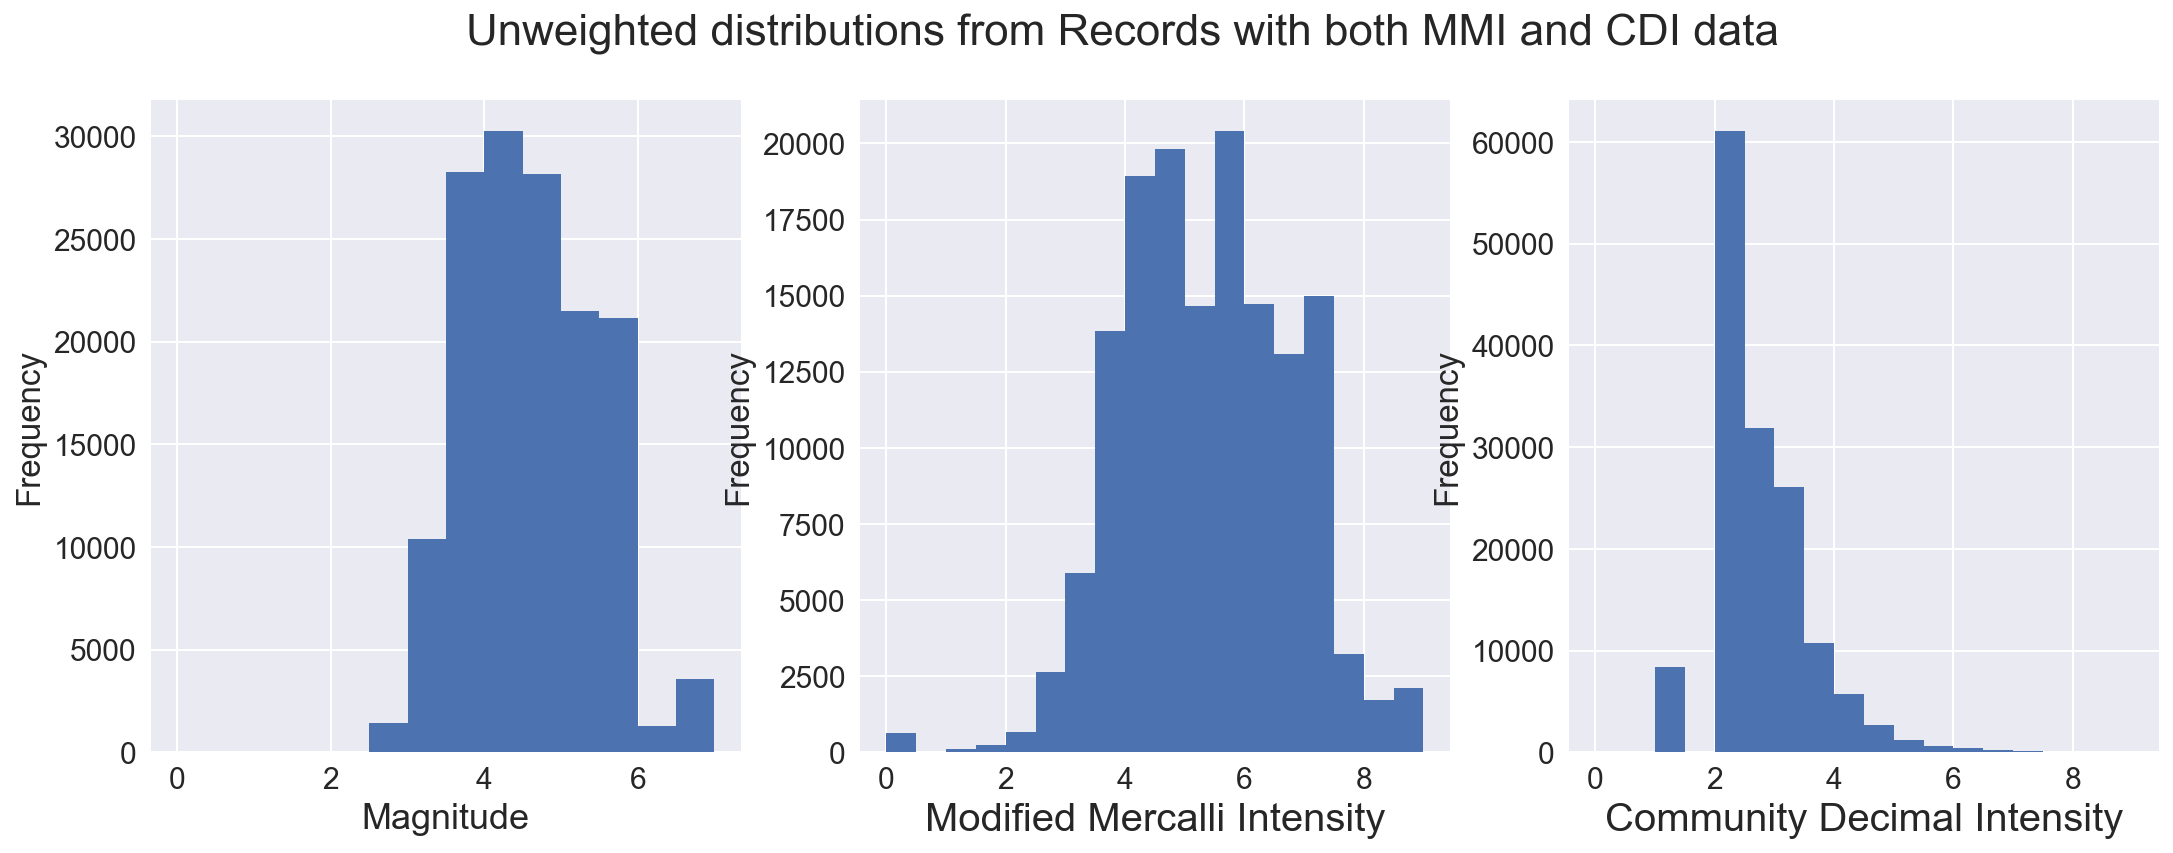

In [44]:
# Plot the unweighted distributions of raw (but filtered to have only records with both mmi and cdi)
sns.set(font_scale=1.5)
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle("Unweighted distributions from Records with both MMI and CDI data", fontsize=22)

df['mag'].plot(kind='hist', bins=14, range=(0,7), ax=axs[0])
df['mmi'].plot(kind='hist', bins=18, range=(0,9), ax=axs[1])
df['cdi'].plot(kind='hist', bins=18, range=(0,9), ax=axs[2])
axs[0].set_xlabel('Magnitude', fontsize=18)
axs[1].set_xlabel('Modified Mercalli Intensity', fontsize=20)
axs[2].set_xlabel('Community Decimal Intensity', fontsize=20)
axs[0].locator_params(numticks=8)
axs[1].locator_params(numticks=10)
axs[2].locator_params(numticks=10)


## Setup initial MLR (multiple linear regression) model

First attempt will use magnitude, depth and distance to predict CDI derived intensity

In [62]:
# import scipy.stats as stats
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict

from sklearn.preprocessing import StandardScaler

In [79]:
# bootstrap with filter to obtain samples more equally distributed across earthquake magnitude

from random import random

# dfw = pd.DataFrame()

idx=0
count= 0
while (len(dfw) < len(df)) and (count<=100000):
    
    if count % 5000 == 0:
        print count, dfw.shape
        
    prn = random()
    sample = df.iloc[idx]
   
    if sample['mag'].item() <= 3:
        weight = 0
    elif sample['mag'].item() <= 3.5:
        weight = 0.8
    elif sample['mag'].item() <= 4:
        weight = 0.9
    elif sample['mag'].item() <= 5:
        weight = 0.9
    elif sample['mag'].item() <= 5.5:
        weight = 0.9 
    elif sample['mag'].item() <= 6:
        weight = 0.9
    else:
        weight = 0
        
    if prn >= weight:
        dfw = dfw.append(sample, ignore_index=True)
    
    count +=1
    idx += 1    
    if idx == len(df):
        idx = 0
    
dfw.shape


0 (45170, 21)
5000 (45629, 21)
10000 (46135, 21)
15000 (46611, 21)
20000 (47160, 21)
25000 (47741, 21)
30000 (48280, 21)
35000 (48803, 21)
40000 (49415, 21)
45000 (49945, 21)
50000 (50539, 21)
55000 (51117, 21)
60000 (51643, 21)
65000 (53723, 21)
70000 (54195, 21)
75000 (54673, 21)
80000 (55212, 21)
85000 (56277, 21)
90000 (56810, 21)
95000 (57628, 21)
100000 (58880, 21)


(58880, 21)

In [81]:
# dfw.to_csv("./dyfi_weighted_bootstrap", index=False)

In [47]:
dfw = pd.read_csv("./dyfi_weighted_bootstrap.csv")

In [48]:
# Drop records with MMI = 0, as these all have CDI of 1 or greater, and all were magnitude 2.5, and thus a 
# maximum intenisty of 0 is implausible at best, much more likely the MMI was incorrectly entered as 0 when there 
# wasn't an MMI rating asigned.   In addition, these would be disproportionatly represented in the weighted
# bootstrap, and this is not desirable for suspect records.

dfw = dfw[dfw['mmi'] != 0]

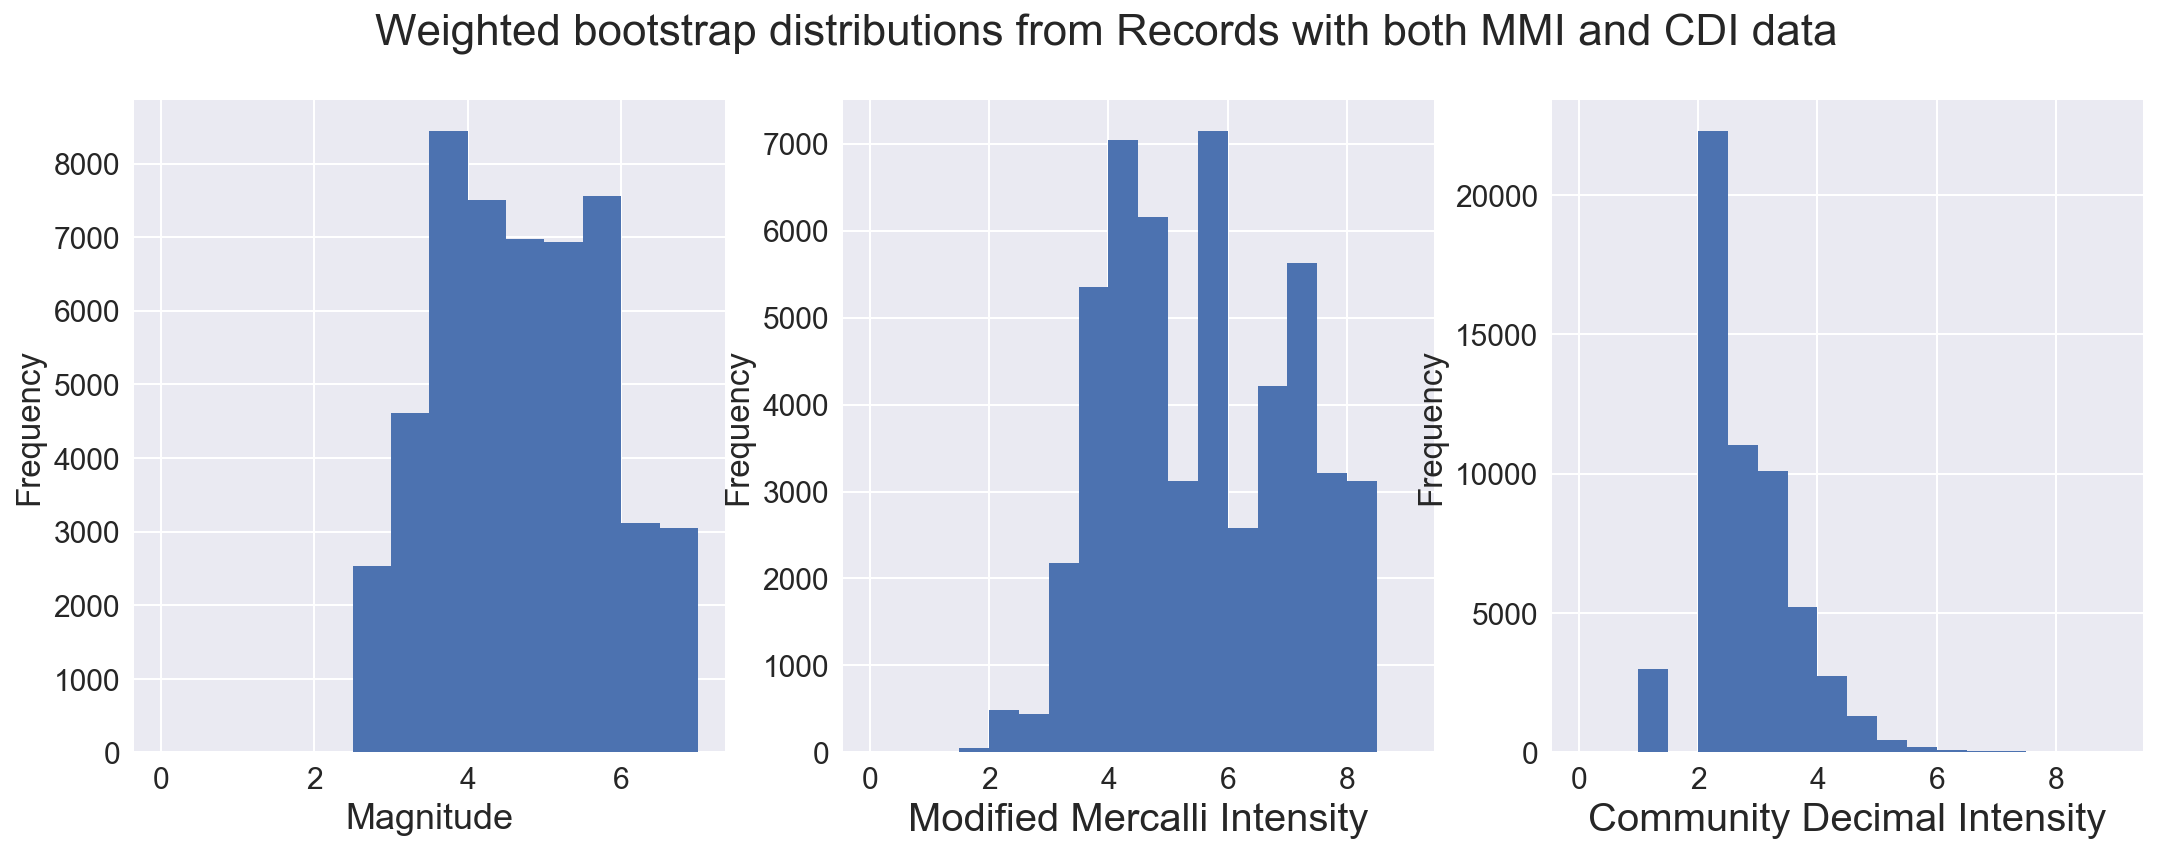

In [49]:
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle("Weighted bootstrap distributions from Records with both MMI and CDI data", fontsize=22)
dfw['mag'].plot(kind='hist', bins=14, range=(0,7), ax=axs[0])
dfw['mmi'].plot(kind='hist', bins=18, range=(0,9), ax=axs[1])
dfw['cdi'].plot(kind='hist', bins=18, range=(0,9), ax=axs[2])
axs[0].set_xlabel('Magnitude', fontsize=18)
axs[1].set_xlabel('Modified Mercalli Intensity', fontsize=20)
axs[2].set_xlabel('Community Decimal Intensity', fontsize=20)
axs[0].locator_params(numticks=9)


In [50]:
dfw.describe()

,cdi,cdi_Latitude,cdi_Longitude,depth,distance,is_OK,is_epi_dist,is_suspect,log_depth,log_dist,mag,mmi,q_lat,q_long,responses
count,56498.000000,56498.000000,56498.000000,56498.000000,56498.000000,56498.000000,56498.000000,56498.0,56498.000000,56498.000000,56498.000000,56498.000000,56498.000000,56498.000000,56498.000000
mean,2.705926,37.440126,-100.906483,10.006949,256.001628,0.294524,0.359977,0.0,0.916796,2.191530,4.920147,5.927629,37.211407,-101.035982,19.694131
std,0.884793,3.428177,16.085154,6.538479,234.703004,0.455832,0.479998,0.0,0.286997,0.491686,1.253231,1.803250,3.731349,16.210573,62.369747
min,1.000000,25.570000,-124.358600,0.010000,1.000000,0.000000,0.000000,0.0,-2.000000,0.000000,2.660000,1.000000,27.681400,-126.267667,1.000000
25%,2.000000,34.706600,-118.080225,5.287000,75.000000,0.000000,0.000000,0.0,0.723209,1.875061,3.820000,4.400000,35.268667,-116.447500,1.000000
50%,2.600000,37.065100,-97.412100,8.200000,191.000000,0.000000,0.000000,0.0,0.913814,2.281033,4.800000,5.800000,36.489800,-97.530600,2.000000
75%,3.300000,39.338875,-89.393900,11.937000,364.000000,1.000000,1.000000,0.0,1.076895,2.561101,5.800000,7.300000,38.215167,-88.900000,11.000000
max,8.300000,51.300000,-66.120000,58.065000,3902.000000,1.000000,1.000000,0.0,1.763914,3.591287,7.200000,9.200000,48.958333,-69.730000,5750.000000


In [51]:
dfw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56498 entries, 0 to 58879
Data columns (total 21 columns):
cdi              56498 non-null float64
cdi_Latitude     56498 non-null float64
cdi_Longitude    56498 non-null float64
city             56498 non-null object
depth            56498 non-null float64
distance         56498 non-null float64
id               56498 non-null object
is_OK            56498 non-null float64
is_epi_dist      56498 non-null float64
is_suspect       56498 non-null float64
log_depth        56498 non-null float64
log_dist         56498 non-null float64
mag              56498 non-null float64
mag_type         56498 non-null object
mmi              56498 non-null float64
q_lat            56498 non-null float64
q_long           56498 non-null float64
q_time           56498 non-null object
responses        56498 non-null float64
state            55771 non-null object
zip_code         56498 non-null object
dtypes: float64(15), object(6)
memory usage: 9.5+ MB


In [52]:
dfw[(dfw['responses'] >=5)]['id'].unique().size

536

In [53]:
# Set up for initial model 

factors = [ x for x in df.columns if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code',  'mag_type', 'depth', 'is_OK', 'is_epi_dist', \
                                               'cdi', 'mmi', 'dist_std_dev', 'log_depth']]
print factors
X = dfw[(dfw['responses'] >=5)][factors]
y = dfw[(dfw['responses'] >=5)]['cdi'].values
X = X.drop(['responses'], 1)
factors = [ x for x in df.columns if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code', 'mag_type', 'depth', 'is_OK', 'responses', 'is_epi_dist', \
                                               'cdi', 'dist_std_dev', 'log_depth']]


print y[0:5]
print len(X)
X.head()

['responses', 'distance', 'mag', 'log_dist']
[ 3.6  3.8  3.7  4.8  2.1]
21583


,distance,mag,log_dist
0,3226.0,5.8,3.508664
1,1291.0,5.8,3.110926
7,611.0,5.8,2.786041
8,671.0,5.8,2.826723
14,558.0,5.8,2.746634


In [54]:
X = X[['mag', 'distance', 'log_dist']]

In [55]:
X.describe()

,mag,distance,log_dist
count,21583.000000,21583.00000,21583.000000
mean,5.417043,221.81453,2.138951
std,1.259737,188.67266,0.491341
min,2.660000,3.00000,0.477121
25%,4.450000,67.00000,1.826075
50%,5.700000,183.00000,2.262451
75%,6.020000,332.00000,2.521138
max,7.200000,3226.00000,3.508664


In [56]:
factors = [ x for x in X.columns]
factors

['mag', 'distance', 'log_dist']

In [57]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [58]:
# Standardize - almost always a good idea, and for many models a necessary practice.  
# Nothing in this dataset has characteristics that would preclude standardization

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# Fit and transform the data for training set using standard scaler.
# Only Transform the test set.

Xstd_train = ss.fit_transform(X_train[factors])
Xstd_test = ss.transform(X_test[factors])

# Check reasonablness of result
print Xstd_train.mean(), Xstd_train.std()
print Xstd_train.shape
print
print Xstd_test.mean(), Xstd_test.std()
print Xstd_test.shape


5.46503803065e-17 1.0
(16187, 3)

0.0103530614909 0.994348994193
(5396, 3)


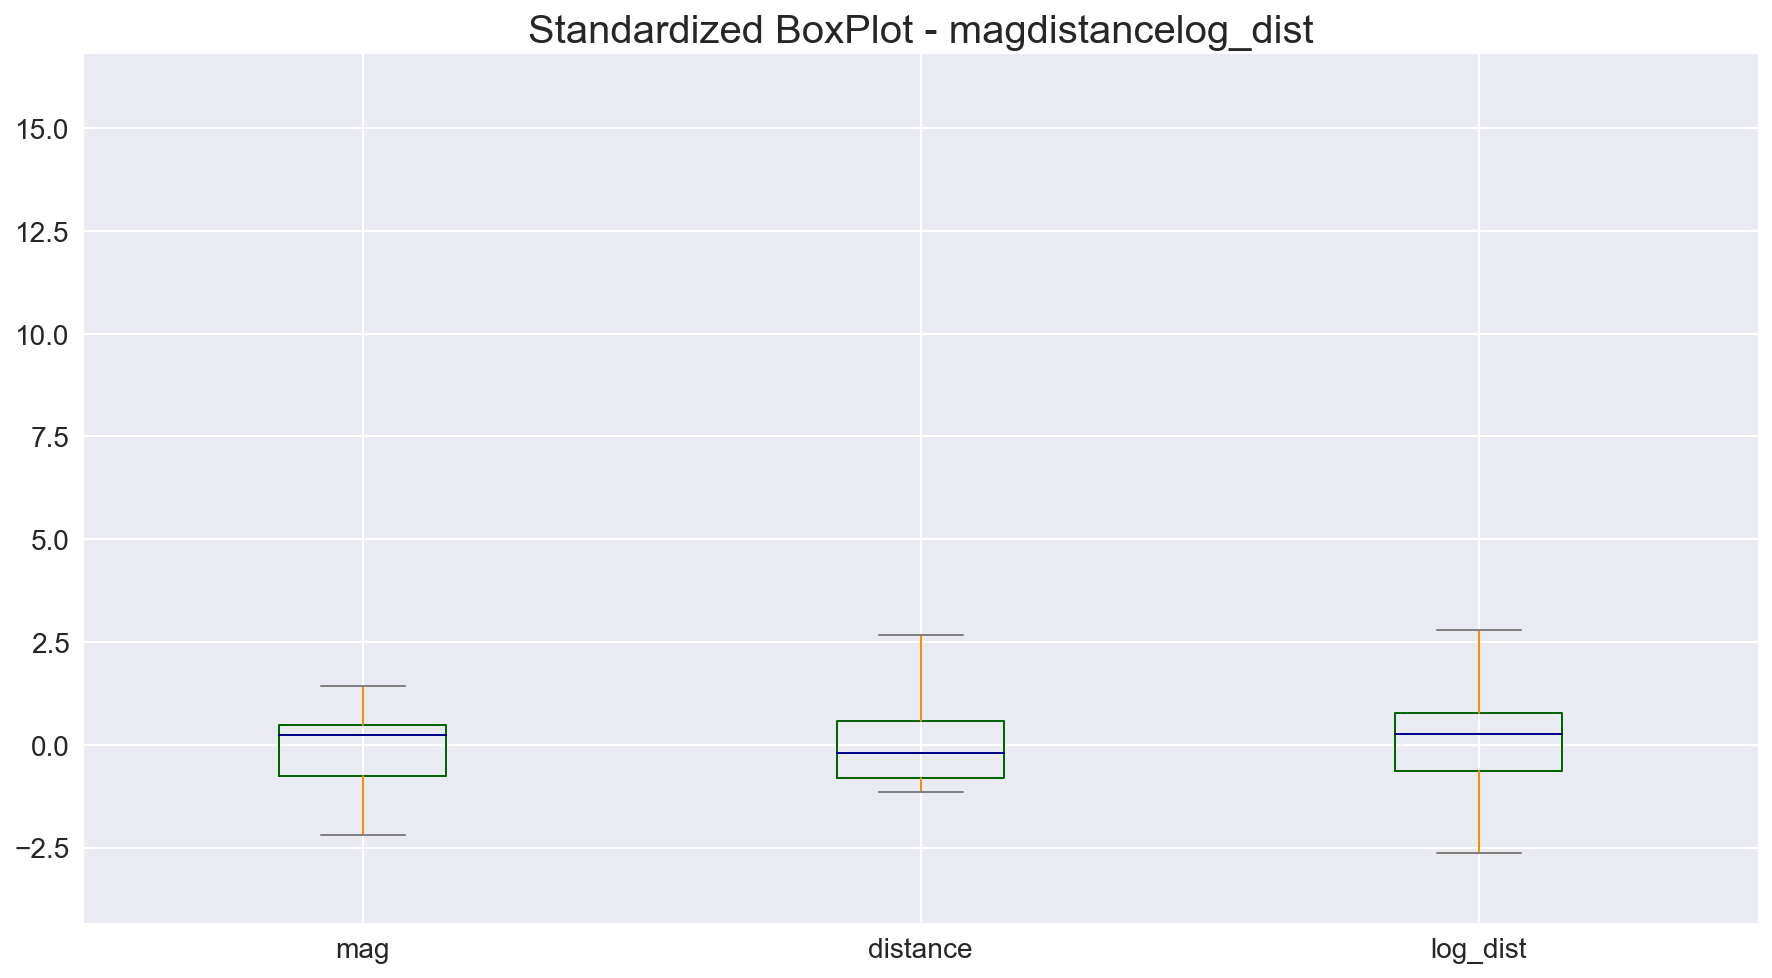

In [59]:
# Box plot vs. Scatter plot vs. Histogram.  While all of these give you a view of the spread of your data, the
#   - Box plot best at showing outliers if there are any
#   - Histogram gives the easiest and most intuitive look at the distribution
#   - Scatter plot is best at showing the correlation between two variables, and the "tightness" of that correlation

# The Rate should not be plotted on same box plot as the Math and Verbal because the scale, and also range, 
# are not the same, or even similar.

# Set colors, as this shows up better on the grey back ground
color = dict(boxes='DarkGreen', whiskers='DarkOrange', \
                medians='DarkBlue', caps='Gray')


ax = pd.DataFrame(Xstd_train, columns=factors)[factors].plot.box(color=color,\
                         figsize=(15,8), fontsize=14, \
                         title="Standardized BoxPlot - " + ''.join([str(x) for x in factors]))
ax.title.set_size(20)


In [60]:
# Compute baseline

baseline = np.mean(y)
print baseline

3.16270212667


score: 0.187094928057
[ 0.46413487 -0.0183804  -0.34338113]
3.15653302032
MSE:  0.539112528625
RMSE:  0.734242826744
Baseline: 3.16270212667
Baseline - MSE: 2.62358959805


/Users/erhepp/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


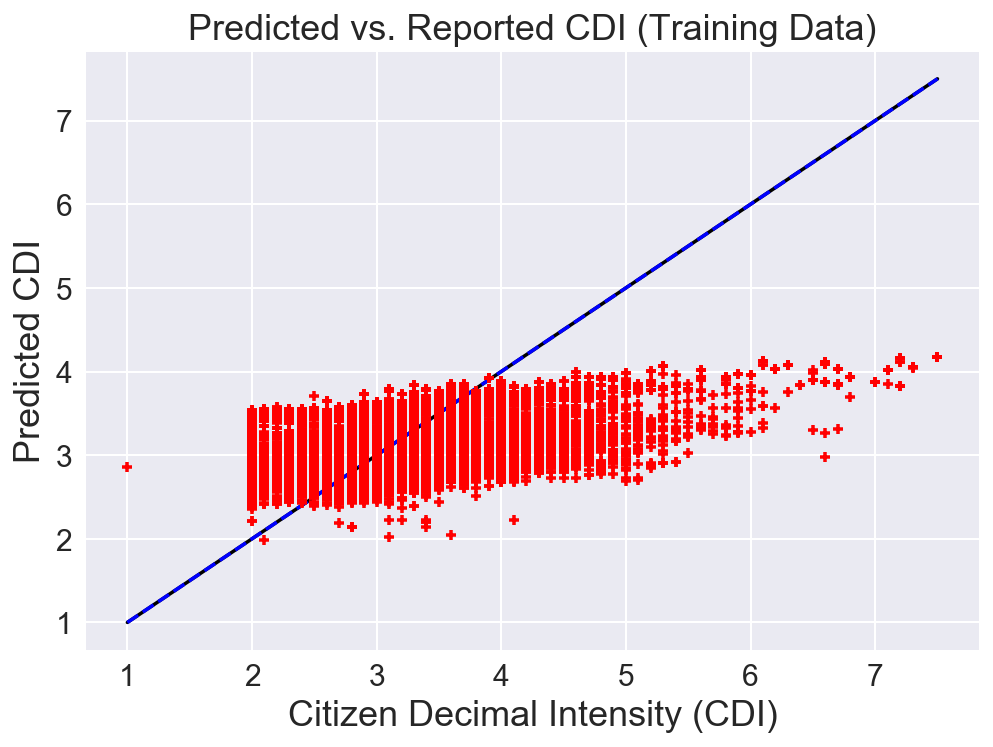

In [63]:
# Linear Regression Model

lm = linear_model.LinearRegression()

model = lm.fit(Xstd_train, y_train)

# Linear Regression with plot of predicted vs. actual y
predictions = model.predict(Xstd_train)
score = model.score(Xstd_train, y_train)
print "score:", score
print model.coef_
print model.intercept_

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

plt.scatter(y_train, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Predicted vs. Reported CDI (Training Data)', fontsize=18)

# I did this just to see how closely the training data was fit to itself.  When compared to the 
# predictions for test data, it will give a good indication if this model over fits

Score: 0.178964943401
MSE:  0.57360383618
RMSE:  0.757366381734
Baseline: 3.16270212667
Baseline - MSE: 2.58909829049


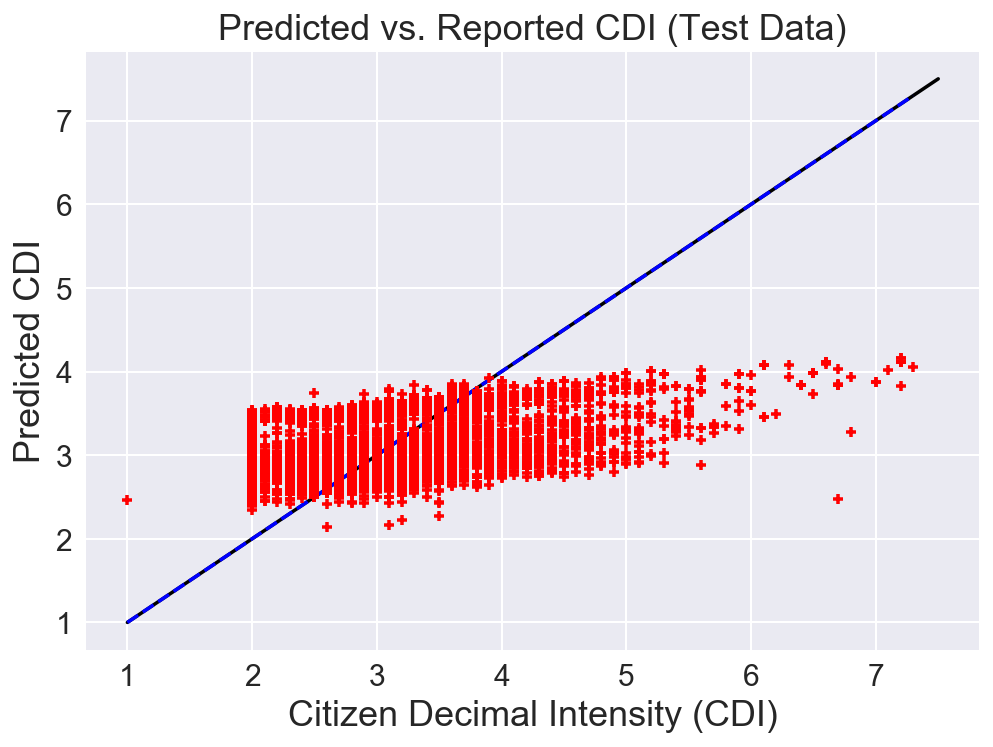

In [64]:
# Using the model above, now fit and plot against the test data
# Linear Regression with plot of predicted vs. actual y

predictions = model.predict(Xstd_test)
score = model.score(Xstd_test, y_test)
print "Score:", score

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

# pd.DataFrame(zip(all_sig_factors, model.coef_), columns=['factors', 'coefficients'])
# df_model_summary = pd.DataFrame([['LM', 'All Factors', len(factors), score, mse, rmse, baseline]], \
#                                 columns=['Model', 'Factors', '# Factors','Score', 'MSE', 'RMSE', 'Baseline'])

plt.scatter(y_test, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Predicted vs. Reported CDI (Test Data)', fontsize=18)

# T

In [65]:
m1_coef_df = pd.DataFrame({
        'features': X.columns,
        'coefficients': model.coef_,
    })
m1_coef_df.set_index('features', inplace=True)
m1_coef_df

,coefficients
features,
mag,0.464135
distance,-0.018380
log_dist,-0.343381


In [66]:
# Scale the coefficients back to normal space
m1_coef_df['unscaled coeffs'] = m1_coef_df['coefficients']/ss.scale_
print "intercept:", 
m1_coef_df

intercept:

,coefficients,unscaled coeffs
features,,
mag,0.464135,0.368160
distance,-0.018380,-0.000097
log_dist,-0.343381,-0.699877


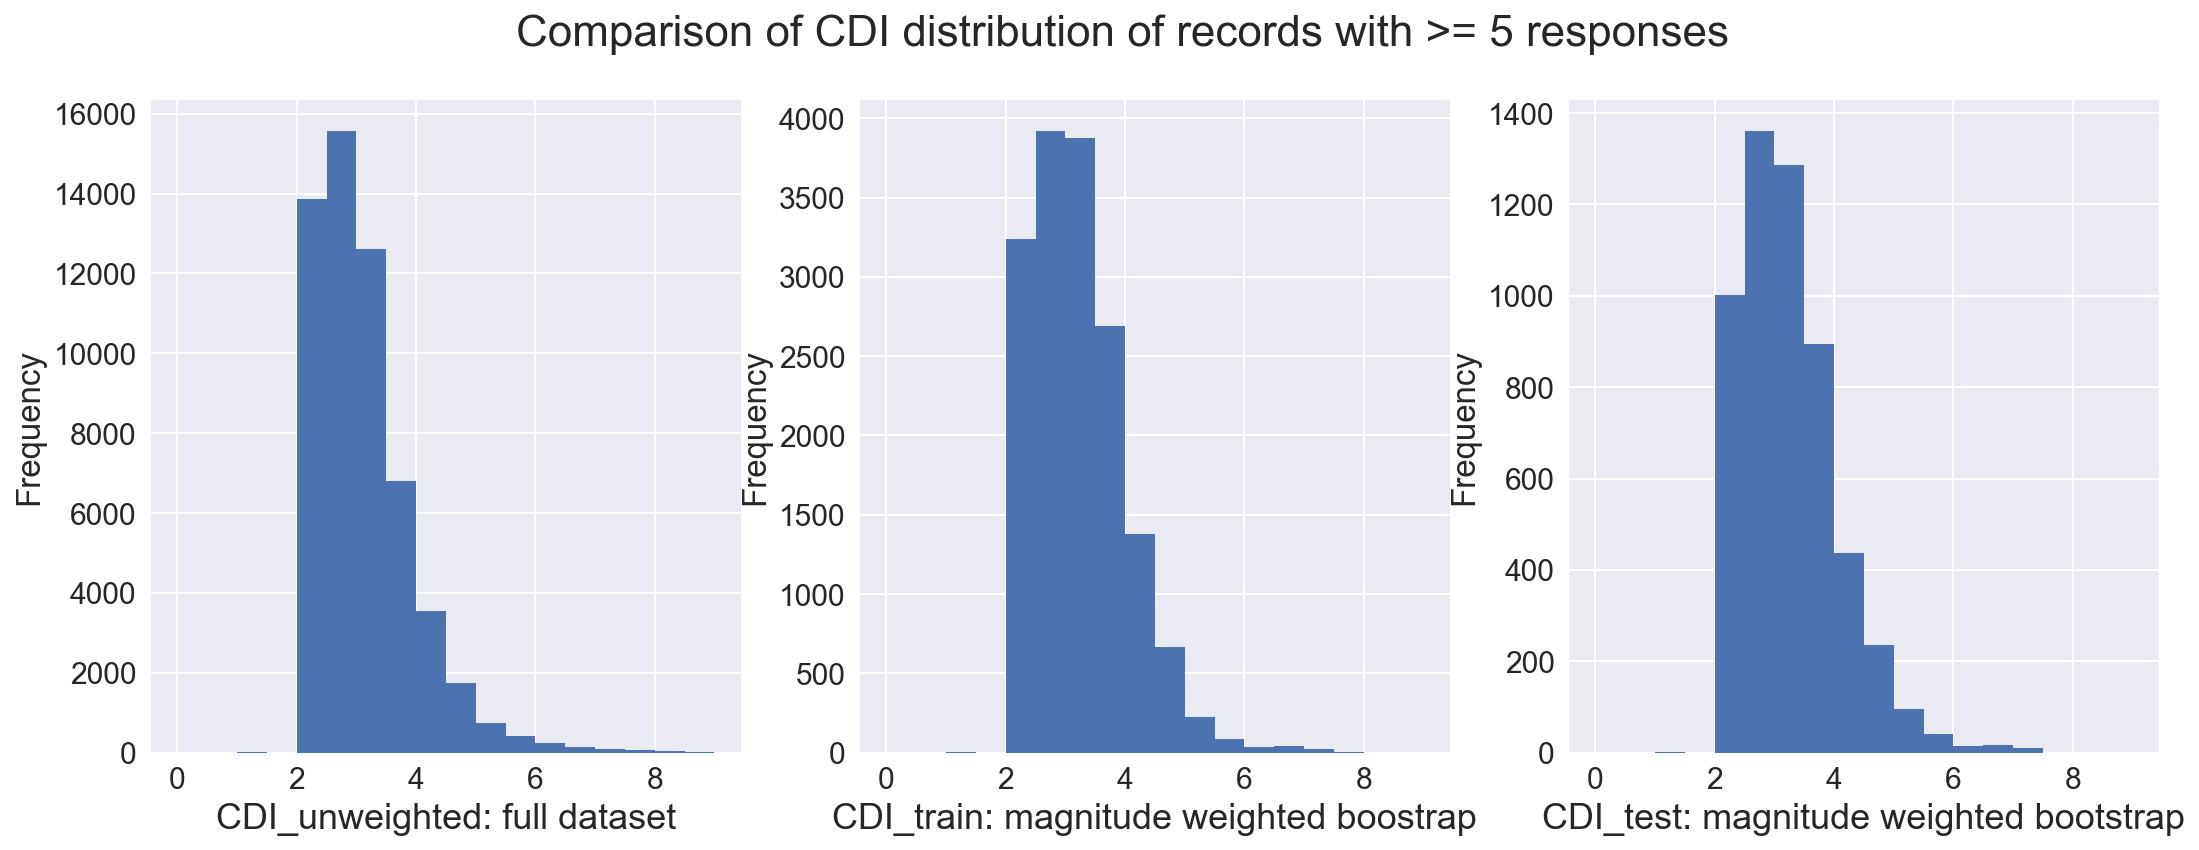

In [67]:
# Plot distribution of target for train and test datsets

# Seaborn is just a quick way to adjust font scale that seems to apply to matplotlib 
# graphs drawn after this is called
import seaborn as sns
sns.set(font_scale=1.5)

fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle("Comparison of CDI distribution of records with >= 5 responses", fontsize=22)

df[df['responses']>=5]['cdi'].plot(kind='hist', bins=18, range=(0,9), ax=axs[0])
pd.DataFrame(y_train, columns=['y_train'])['y_train'].plot(kind='hist', bins=18, range=(0,9), ax=axs[1])
pd.DataFrame(y_test, columns=['y_test'])['y_test'].plot(kind='hist', bins=18, range=(0,9), ax=axs[2])
axs[0].set_xlabel('CDI_unweighted: full dataset', fontsize=18)
axs[1].set_xlabel('CDI_train: magnitude weighted boostrap', fontsize=18)
axs[2].set_xlabel('CDI_test: magnitude weighted bootstrap', fontsize=18)


## Calculators for USGS equations and Schroyer Oklahoma equation

The Western equation is as follows:  

I = 1.01M - 0.00054D - 1.72logD + 1.15  

USGS equation for the Eastern US is as follows:  

I = 1.29M - 0.00051*D - 2.16logD + 1.60  

Schroyer Oklahoma equation  


I = 0.93M - 1.15logD + 1.14

In [68]:
def USGS_West(mag, dist):
    return 1.01 * mag - 0.00054 * dist - 1.72 * np.log10(dist) + 1.15

def USGS_East(mag, dist):
    return 1.29 * mag - 0.00051 * dist - 2.16 * np.log10(dist) + 1.60

def Schroyer_OK(mag, dist):
    return 0.93 * mag - 1.15 * np.log10(dist) + 1.14

def USGS_West_CDI(mag, dist):
    c1 = 12.27
    c2 = 2.770
    c3 = 0.1304
    c4 = -1.30
    c5 = -0.0007070
    c6 = 1.95
    c7 = -0.577
    h = 14.0
    Rt = 30.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)

def USGS_East_CDI(mag, dist):
    c1 = 11.72
    c2 = 2.36
    c3 = 0.1155
    c4 = -0.44
    c5 = -0.002044
    c6 = 2.31
    c7 = -0.479
    h = 17.0
    Rt = 80.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)


def This_model(mag, dist):
    return  m1_coef_df.loc['mag', 'unscaled coeffs'] * mag \
            +  m1_coef_df.loc['distance', 'unscaled coeffs'] * dist \
            +  m1_coef_df.loc['log_dist', 'unscaled coeffs'] * np.log10(dist) \
            + 2.676   # from unscaled model

# Unstandardized model
# [  3.71819184e-01  -1.07814234e-04  -7.02945023e-01]
# 2.67598635437

# Standardized model
# mag	0.454569	0.361373
# distance	-0.026655	-0.000142
# log_dist	-0.332415	-0.677430

# mag	0.461665	0.366176
# distance	-0.026708	-0.000142
# log_dist	-0.336531	-0.684903

# mag	0.464828	0.368057
# distance	-0.019519	-0.000103
# log_dist	-0.349591	-0.709775

# mag	0.464828	0.368057
# distance	-0.019519	-0.000103
# log_dist	-0.349591	-0.709775

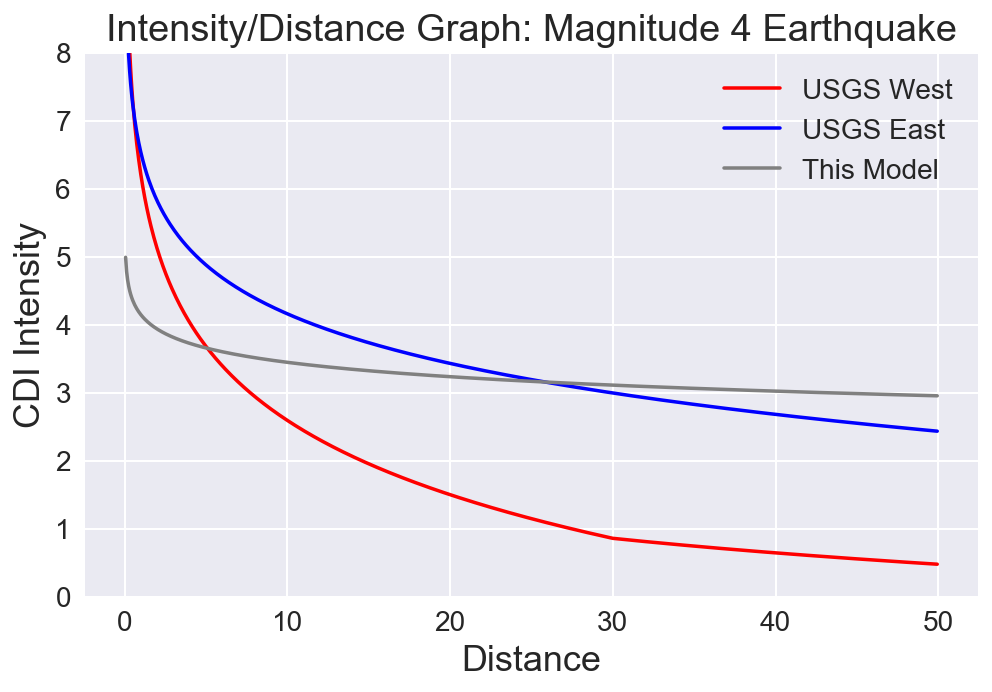

In [69]:
# Generate Distance values
dist = np.arange(0.1, 50*1.61, 0.1)
mag = 4

WI = []
EI = []
TM = []
for i in range(len(dist)):
    WI.append(USGS_West_CDI(mag, dist[i]/1.61))
    EI.append(USGS_East_CDI(mag, dist[i]/1.61))
    TM.append(This_model(mag, dist[i]/1.61))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dist/1.61, WI, label='USGS West', color='r') 
ax.plot(dist/1.61, EI, label='USGS East', color='b')
ax.plot(dist/1.61, TM, label='This Model', color='grey')
x1,x2,y1,y2  = ax.axis()
ax.axis((x1,x2,0,8))
plt.xlabel('Distance', fontsize=18)
plt.ylabel('CDI Intensity', fontsize=18)
plt.tick_params(labelsize=14)
title_string = 'Intensity/Distance Graph: Magnitude ' + str(mag) + ' Earthquake'
plt.title(title_string, fontsize=19)
ax.legend(fontsize=14)

plt.show()

## Model MMI instead of CDI

In [183]:
dfw[(dfw['responses'] >=5)]['id'].unique().size

536

In [388]:
# Set up for initial model 

factors = [ x for x in df.columns if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code',  'mag_type', 'depth', 'is_OK', 'is_epi_dist', \
                                               'cdi', 'mmi', 'dist_std_dev', 'log_depth']]
print factors
X = dfw[(dfw['responses'] >=5)][factors]
y = dfw[(dfw['responses'] >=5)]['mmi'].values
X = X.drop(['responses'], 1)
factors = [ x for x in df.columns if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code', 'mag_type', 'depth', 'is_OK', 'responses', 'is_epi_dist', \
                                               'cdi', 'dist_std_dev', 'log_depth']]


print y[0:5]
print len(X)
X.head()

['responses', 'distance', 'mag', 'log_dist']
[ 7.3  7.3  7.3  7.3  7.3]
21583


,distance,mag,log_dist
0,3226.0,5.8,3.508664
1,1291.0,5.8,3.110926
7,611.0,5.8,2.786041
8,671.0,5.8,2.826723
14,558.0,5.8,2.746634


In [389]:
X = X[['mag', 'distance', 'log_dist']]

In [390]:
X.describe()

,mag,distance,log_dist
count,21583.000000,21583.00000,21583.000000
mean,5.417043,221.81453,2.138951
std,1.259737,188.67266,0.491341
min,2.660000,3.00000,0.477121
25%,4.450000,67.00000,1.826075
50%,5.700000,183.00000,2.262451
75%,6.020000,332.00000,2.521138
max,7.200000,3226.00000,3.508664


In [391]:
factors = [ x for x in X.columns]
factors

['mag', 'distance', 'log_dist']

In [392]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [399]:
# Standardize - almost always a good idea, and for many models a necessary practice.  
# Nothing in this dataset has characteristics that would preclude standardization

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# Fit and transform the data for training set using standard scaler.
# Only Transform the test set.

Xstd_train = ss.fit_transform(X_train[factors])
Xstd_test = ss.transform(X_test[factors])

# Check reasonablness of result
print Xstd_train.mean(), Xstd_train.std()
print Xstd_train.shape
print
print Xstd_test.mean(), Xstd_test.std()
print Xstd_test.shape


-1.19396814806e-16 1.0
(16187, 3)

-0.0047153353939 1.00693562917
(5396, 3)


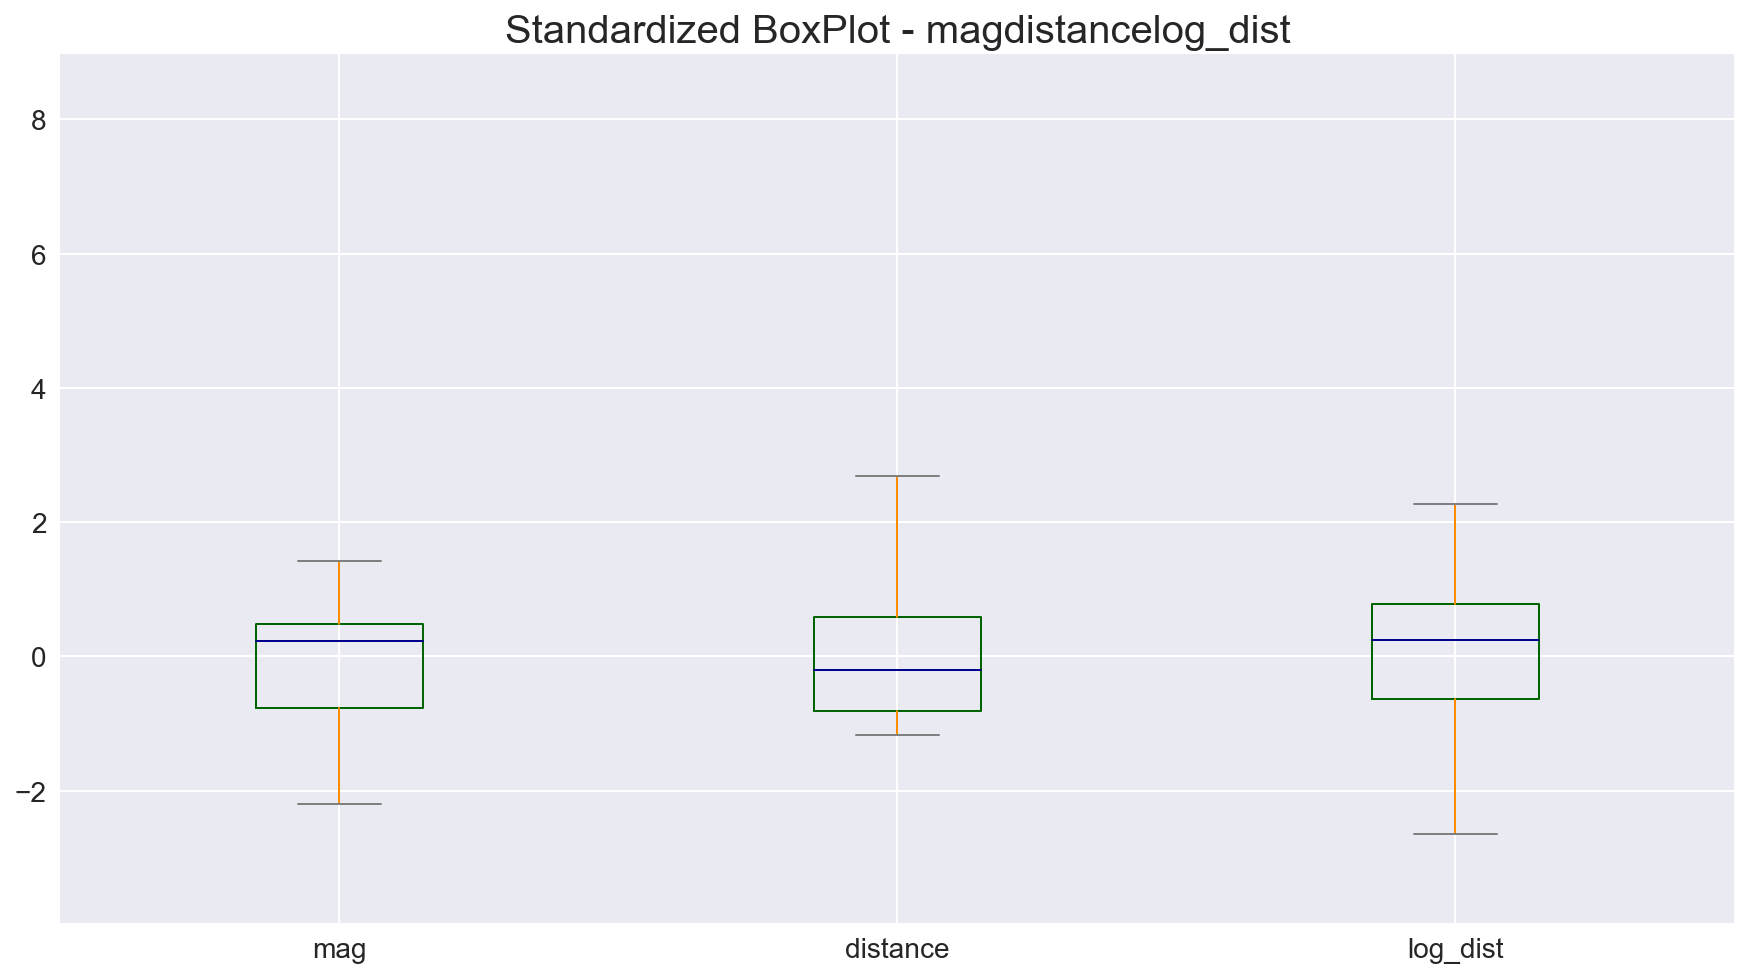

In [400]:
# Box plot vs. Scatter plot vs. Histogram.  While all of these give you a view of the spread of your data, the
#   - Box plot best at showing outliers if there are any
#   - Histogram gives the easiest and most intuitive look at the distribution
#   - Scatter plot is best at showing the correlation between two variables, and the "tightness" of that correlation

# The Rate should not be plotted on same box plot as the Math and Verbal because the scale, and also range, 
# are not the same, or even similar.

# Set colors, as this shows up better on the grey back ground
color = dict(boxes='DarkGreen', whiskers='DarkOrange', \
                medians='DarkBlue', caps='Gray')


ax = pd.DataFrame(Xstd_train, columns=factors)[factors].plot.box(color=color,\
                         figsize=(15,8), fontsize=14, \
                         title="Standardized BoxPlot - " + ''.join([str(x) for x in factors]))
ax.title.set_size(20)


In [369]:
# Compute baseline

baseline = np.mean(y)
print baseline

6.69300699625


score: 0.908374902237
[ 1.87525013 -0.01654697 -0.21687931]
6.69215790449
MSE:  0.302799433582
RMSE:  0.550272145018
Baseline: 6.69300699625
Baseline - MSE: 6.39020756266


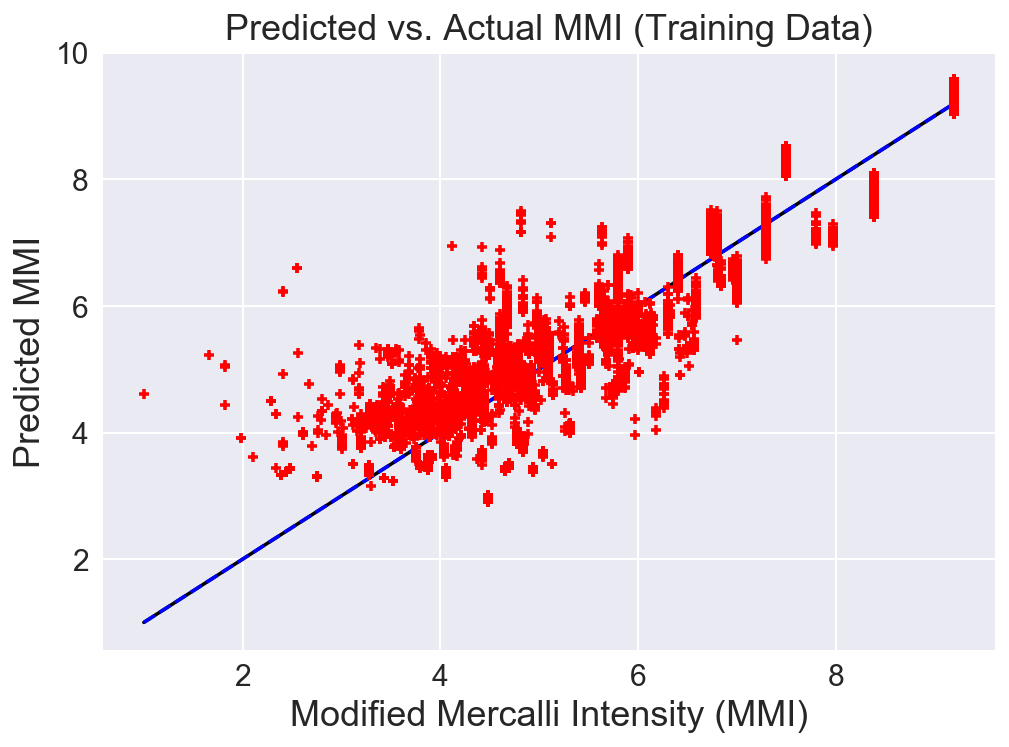

In [401]:
# Linear Regression Model

lm = linear_model.LinearRegression()

model = lm.fit(Xstd_train, y_train)

# Linear Regression with plot of predicted vs. actual y
predictions = model.predict(Xstd_train)
score = model.score(Xstd_train, y_train)
print "score:", score
print model.coef_
print model.intercept_

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline

plt.scatter(y_train, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k', linestyle='dashed', color="b")
plt.xlabel('Modified Mercalli Intensity (MMI)', fontsize=18)
plt.ylabel('Predicted MMI', fontsize=18)
plt.title('Predicted vs. Actual MMI (Training Data)', fontsize=18)

# I did this just to see how closely the training data was fit to itself.  When compared to the 
# predictions for test data, it will give a good indication if this model over fits

In [ ]:
score: 0.908183314688
[  1.49146270e+00  -1.06804706e-04  -4.25280516e-01]
-0.452723811756

Score: 0.908333400279
MSE:  0.309913786629
RMSE:  0.556699009006
Baseline: 6.69300699625
Baseline - MSE: 6.38309320962


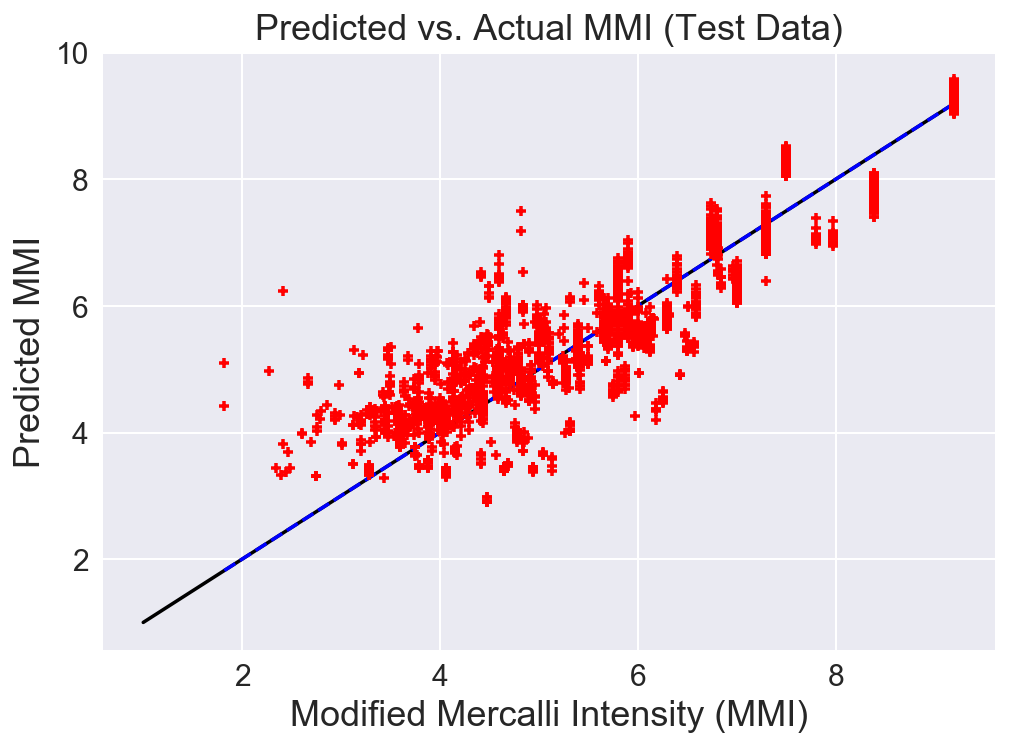

In [402]:
# Using the model above, now fit and plot against the test data
# Linear Regression with plot of predicted vs. actual y

predictions = model.predict(Xstd_test)
score = model.score(Xstd_test, y_test)
print "Score:", score

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline

# pd.DataFrame(zip(all_sig_factors, model.coef_), columns=['factors', 'coefficients'])
# df_model_summary = pd.DataFrame([['LM', 'All Factors', len(factors), score, mse, rmse, baseline]], \
#                                 columns=['Model', 'Factors', '# Factors','Score', 'MSE', 'RMSE', 'Baseline'])

plt.scatter(y_test, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k', linestyle='dashed', color="b")
plt.xlabel('Modified Mercalli Intensity (MMI)', fontsize=18)
plt.ylabel('Predicted MMI', fontsize=18)
plt.title('Predicted vs. Actual MMI (Test Data)', fontsize=18)

# T

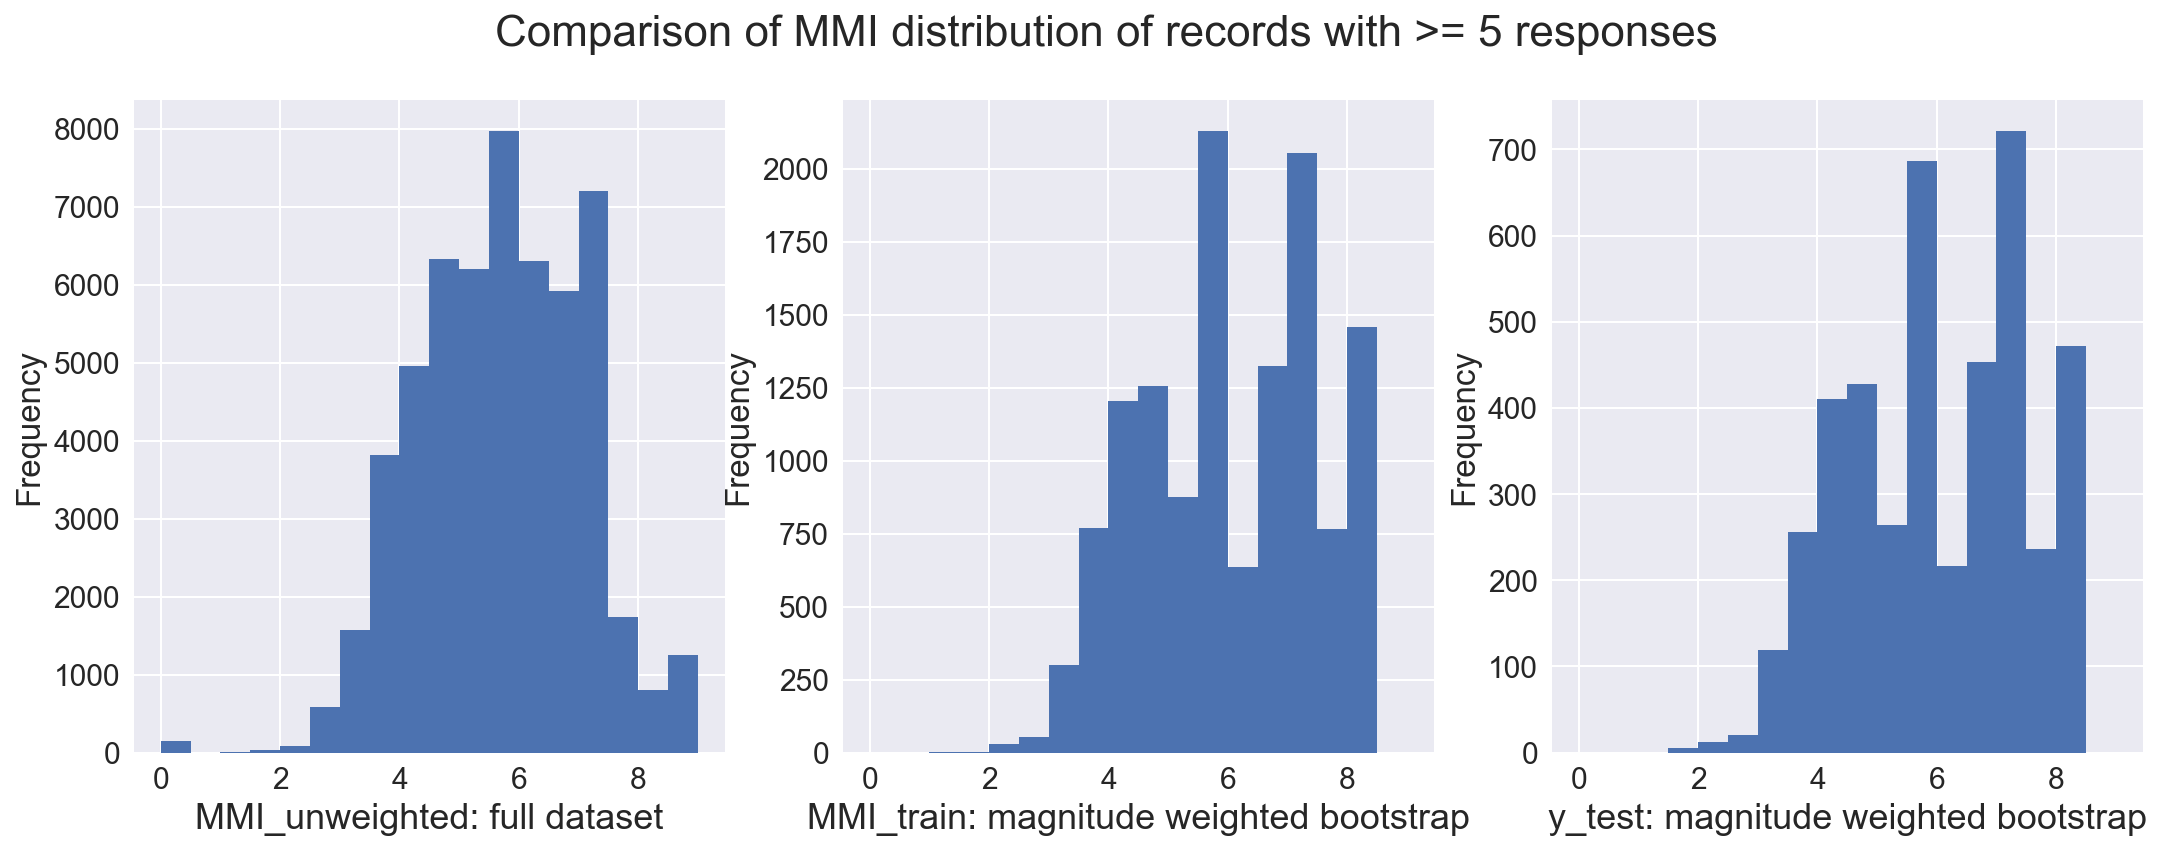

In [129]:
# Plot distribution of target for train and test datsets

# Seaborn is just a quick way to adjust font scale that seems to apply to matplotlib 
# graphs drawn after this is called
import seaborn as sns
sns.set(font_scale=1.5)

fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle("Comparison of MMI distribution of records with >= 5 responses", fontsize=22)

df[df['responses']>=5]['mmi'].plot(kind='hist', bins=18, range=(0,9), ax=axs[0])
pd.DataFrame(y_train, columns=['y_train'])['y_train'].plot(kind='hist', bins=18, range=(0,9), ax=axs[1])
pd.DataFrame(y_test, columns=['y_test'])['y_test'].plot(kind='hist', bins=18, range=(0,9), ax=axs[2])
axs[0].set_xlabel('MMI_unweighted: full dataset', fontsize=18)
axs[1].set_xlabel('MMI_train: magnitude weighted bootstrap', fontsize=18)
axs[2].set_xlabel('y_test: magnitude weighted bootstrap', fontsize=18)


In [403]:
m2_coef_df = pd.DataFrame({
        'features': X.columns,
        'coefficients': model.coef_,
    })
m2_coef_df.set_index('features', inplace=True)
m2_coef_df

,coefficients
features,
mag,1.875250
distance,-0.016547
log_dist,-0.216879


In [ ]:
[  1.49284551e+00  -8.78170697e-05  -4.41899115e-01]
-0.426897064277

In [404]:
# Scale the coefficients back to normal space
m2_coef_df['unscaled coeffs'] = m2_coef_df['coefficients']/ss.scale_
print "intercept:", 
m2_coef_df

intercept:

,coefficients,unscaled coeffs
features,,
mag,1.875250,1.492846
distance,-0.016547,-0.000088
log_dist,-0.216879,-0.441899


In [419]:
def USGS_West(mag, dist):
    return 1.01 * mag - 0.00054 * dist - 1.72 * np.log10(dist) + 1.15

def USGS_East(mag, dist):
    return 1.29 * mag - 0.00051 * dist - 2.16 * np.log10(dist) + 1.60

def Schroyer_OK(mag, dist):
    return 0.93 * mag - 1.15 * np.log10(dist) + 1.14

def USGS_West_CDI(mag, dist):
    c1 = 12.27
    c2 = 2.770
    c3 = 0.1304
    c4 = -1.30
    c5 = -0.0007070
    c6 = 1.95
    c7 = -0.577
    h = 14.0
    Rt = 30.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)

def USGS_East_CDI(mag, dist):
    c1 = 11.72
    c2 = 2.36
    c3 = 0.1155
    c4 = -0.44
    c5 = -0.002044
    c6 = 2.31
    c7 = -0.479
    h = 17.0
    Rt = 80.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)


def mmi_model(mag, dist):
    return  m2_coef_df.loc['mag', 'coefficients'] * mag \
            +  m2_coef_df.loc['distance', 'coefficients'] * dist \
            +  m2_coef_df.loc['log_dist', 'coefficients'] * np.log10(dist) \
            - 0.439    # From unstandardized model

            
# Unstandardized coefficients
# [  1.49110962e+00  -8.33967381e-05  -4.34428016e-01]
# -0.438814353933

# [  1.48802274e+00  -1.10547324e-04  -4.26217281e-01]
# -0.431796863491
# mag	1.488023
# distance	-0.000111
# log_dist	-0.426217

# Standardized coefficients
# mag	1.876363	1.494177
# distance	-0.017439	-0.000092
# log_dist	-0.214163	-0.436861        
        
# mag	1.881119	1.491568
# distance	-0.015402	-0.000081
# log_dist	-0.211100	-0.428273        
        
        


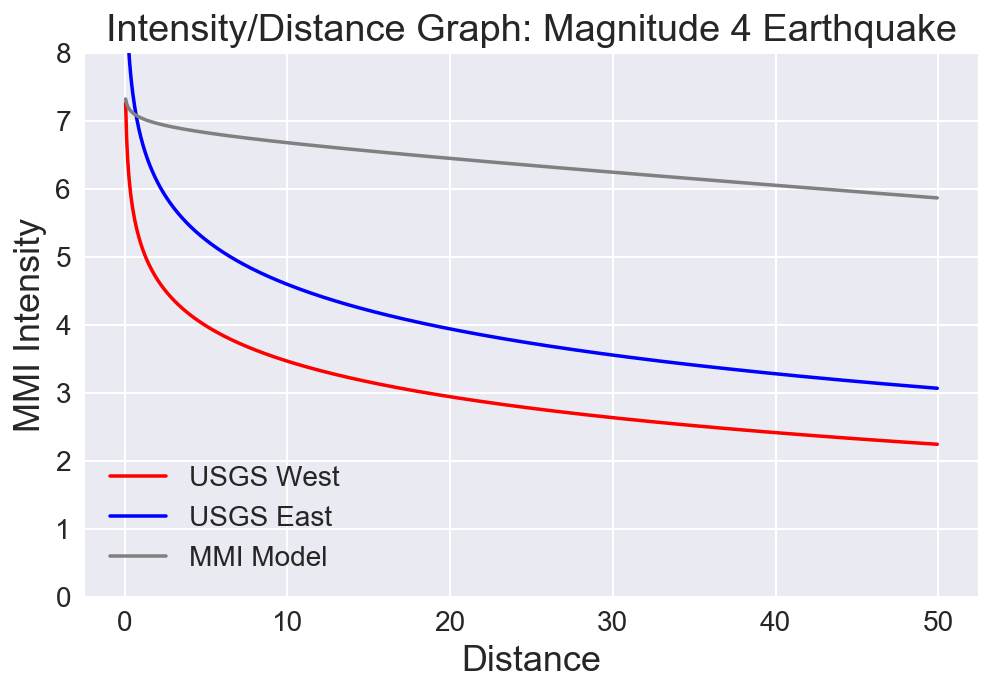

In [420]:
# Generate Distance values
dist = np.arange(0.1, 50*1.61, 0.1)
mag = 4

WI = []
EI = []
WICDI = []
EICDI = []

MM = []
for i in range(len(dist)):
    WI.append(USGS_West(mag, dist[i]/1.61))
    EI.append(USGS_East(mag, dist[i]/1.61))
#     WICDI.append(USGS_West_CDI(mag, dist[i]/1.61))
#     EICDI.append(USGS_East_CDI(mag, dist[i]/1.61))

    MM.append(mmi_model(mag, dist[i]/1.61))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dist/1.61, WI, label='USGS West', color='r') 
ax.plot(dist/1.61, EI, label='USGS East', color='b')
# ax.plot(dist/1.61, WICDI, label='USGS West CDI', color='orange') 
# ax.plot(dist/1.61, EICDI, label='USGS East CDI', color='lightblue')

ax.plot(dist/1.61, MM, label='MMI Model', color='grey')
x1,x2,y1,y2  = ax.axis()
ax.axis((x1,x2,0,8))
plt.xlabel('Distance', fontsize=18)
plt.ylabel('MMI Intensity', fontsize=18)
plt.tick_params(labelsize=14)
title_string = 'Intensity/Distance Graph: Magnitude ' + str(mag) + ' Earthquake'
plt.title(title_string, fontsize=19)
ax.legend(fontsize=14)

plt.show()

## New model to predict CDI, but using additional factors to see if this can be improved

In [70]:
# Copy the weighted bootstrap dataset before adding additional factors
dfmw = dfw.copy()

In [71]:
dfmw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56498 entries, 0 to 58879
Data columns (total 21 columns):
cdi              56498 non-null float64
cdi_Latitude     56498 non-null float64
cdi_Longitude    56498 non-null float64
city             56498 non-null object
depth            56498 non-null float64
distance         56498 non-null float64
id               56498 non-null object
is_OK            56498 non-null float64
is_epi_dist      56498 non-null float64
is_suspect       56498 non-null float64
log_depth        56498 non-null float64
log_dist         56498 non-null float64
mag              56498 non-null float64
mag_type         56498 non-null object
mmi              56498 non-null float64
q_lat            56498 non-null float64
q_long           56498 non-null float64
q_time           56498 non-null object
responses        56498 non-null float64
state            55771 non-null object
zip_code         56498 non-null object
dtypes: float64(15), object(6)
memory usage: 9.5+ MB


In [72]:
def get_hour(timestr):
    timesplit = timestr.split()[1]
    hourstr = timesplit.split(":")[0]
    return hourstr

dfmw['q_tod_hour'] = dfmw['q_time'].map(lambda x: x.split()[1].split(":")[0])


In [73]:
# Dummy the hour of quake occurrence - for example, are dyfi reports different if quakes happen in night hours
dfmw = pd.get_dummies(dfmw, columns=['q_tod_hour'], prefix='H', prefix_sep='_')
dfmw = dfmw.drop('H_23', 1)


In [74]:
# Dummy the magnitude calculation type 
dfmw = pd.get_dummies(dfmw, columns=['mag_type'], prefix='MT', prefix_sep='_')
dfmw = dfmw.drop('MT_mb_lg', 1)
# dfmw.info()

In [75]:
# Add crustal thickness and density data from CRUST1.0
# Laske, G., Masters., G., Ma, Z. and Pasyanos, M., Update on CRUST1.0 - A 1-degree Global Model of Earth's Crust, 
# Geophys. Res. Abstracts, 15, Abstract EGU2013-2658, 2013.

rho = pd.read_csv('/Users/erhepp/fortran/crust1.0/crust1.rho', delim_whitespace=True, header=None, \
                 names=['top_water', 'bottom_water', 'bottom_ice', 'bottom_sed1', 'bottom_sed2', 'bottom_sed3', \
                       'bottom_crust1', 'bottom_crust2', 'bottom_crust3'])

bnds = pd.read_csv('/Users/erhepp/fortran/crust1.0/crust1.bnds', delim_whitespace=True, header=None, \
                 names=['top_water', 'bottom_water', 'bottom_ice', 'bottom_sed1', 'bottom_sed2', 'bottom_sed3', \
                       'bottom_crust1', 'bottom_crust2', 'bottom_crust3'])

print rho.shape, bnds.shape

def get_crust (qlat, qlong, crust_param):
# Return crustal density and thickness data for a given latitude / longitude
# When called with crust_param = 'rho'  returns lat, long and 9 values, 0-2 are surface water and ice, 
#    3-5 are sedimentary layer densities, and 6-8 are crystalline crust densities 
# When called with crust_param = 'bnds' the last value in list depth to the Mohorovičić discontinuity,
#    the boundary between the Earth's crust and mantle.


    # Prevent any float representation uncertainty from pushing latitude and longitude out of range
    if qlat >= 89.999: qlat = 89.999
    if qlat <= -89.999: qlat = -89.999
    if qlong >= 179.999: qlong = 179.999    
    if qlong <= -179.999: qlong = -179.999 
    
    # Find the closest crust1.0 grid locatio to the requested latitude and longitude
    if qlat >= 0:
        rlat = round(qlat - 0.5) + 0.5
    else:
        rlat = round(qlat + 0.5) - 0.5
   
    if qlong >= 0:
        rlong = round(qlong - 0.5) + 0.5
    else:
        rlong = round(qlong + 0.5) - 0.5

    # Determine the index in the crust1.0 files that corresponds to the closest grid location  
    # Information from the crust1.0 readme file
    #   The model is defined from 89.5 to -89.5 deg latitude and -179.5 to 179.5 deg
    #   longitude. Longitudes are the inner loop, i.e. all longitudes are stored
    #   for each latitude, then the next latitude is given. The model starts at
    #   89.5 N and 179.5 W.
    
    dist_from_north = 89.5 - rlat
    dist_from_west = 179.5 + rlong
    idx = int((dist_from_north)*360 + dist_from_west)
    
    # Calculate the latitude and longitude of the crust1.0 datapoint, and return the index loacation
    # latitude, longitude and, for each crustal layer, the density data.
    # Information from the crust1.0 readme file on order and meaning of values
    #    1) top of water
    #    2) bottom of water
    #    3) bottom of ice
    #    4) bottom of sediments 1
    #    5) bottom of sediments 2
    #    6) bottom of sediments 3
    #    7) bottom of cryst. crust 1
    #    8) bottom of cryst. crust 2
    #    9) bottom of cryst. crust 3 = Moho (depth to Moho, not crustal thickness!)

    # For this project, we will only use the density values for sediment and crystalline crust layers
    
    flat = 90 - dist_from_north-0.5
    flon = -180. + dist_from_west+0.5
    if crust_param == 'rho':
        return [idx, flat, flon, round(rho.iloc[idx,0],2), round(rho.iloc[idx,1],2), \
                                             round(rho.iloc[idx,2],2), round(rho.iloc[idx,3],2), \
                                             round(rho.iloc[idx,4],2), round(rho.iloc[idx,5],2), \
                                             round(rho.iloc[idx,6],2), round(rho.iloc[idx,7],2), \
                                             round(rho.iloc[idx,8],2)]
    if crust_param == 'bnds':
        return [idx, flat, flon, round(rho.iloc[idx,0],2), round(bnds.iloc[idx,1],2), \
                                             round(bnds.iloc[idx,2],2), round(bnds.iloc[idx,3],2), \
                                             round(bnds.iloc[idx,4],2), round(bnds.iloc[idx,5],2), \
                                             round(bnds.iloc[idx,6],2), round(bnds.iloc[idx,7],2), \
                                             round(bnds.iloc[idx,8],2)]


(64800, 9) (64800, 9)


In [76]:
dfmw.shape

(56498, 55)

In [77]:
# Must reset the index because the rows where mmi == 0 were dropped
dfmw.reset_index(drop=True, inplace=True)
dfmw.tail()

,cdi,cdi_Latitude,cdi_Longitude,city,depth,distance,id,is_OK,is_epi_dist,is_suspect,...,MT_mblg,MT_mc,MT_md,MT_mh,MT_ml,MT_mlg,MT_mw,MT_mwc,MT_mwr,MT_mww
56493,2.0,34.0649,-118.3832,Beverly Hills,4.25,11.0,ci15507801,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
56494,2.7,33.9949,-118.3993,Culver City,4.25,14.0,ci15507801,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
56495,2.9,34.0179,-118.3920,Culver City,4.25,13.0,ci15507801,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
56496,2.0,33.9144,-118.3491,Hawthorne,4.25,24.0,ci15507801,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
56497,1.0,33.8734,-118.3703,Redondo Beach,4.25,27.0,ci15507801,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [78]:
for idx in range(len(dfmw)):
    dfmw.loc[idx, 'crust_thickness'] = np.abs(get_crust(dfmw.loc[idx, 'q_lat'], dfmw.loc[idx, 'q_long'], 'bnds')[-1])
    dfmw.loc[idx, 'sed_density1'] = get_crust(dfmw.loc[idx, 'q_lat'], dfmw.loc[idx, 'q_long'], 'rho')[6]
    dfmw.loc[idx, 'sed_density2'] = get_crust(dfmw.loc[idx, 'q_lat'], dfmw.loc[idx, 'q_long'], 'rho')[7]
    dfmw.loc[idx, 'sed_density3'] = get_crust(dfmw.loc[idx, 'q_lat'], dfmw.loc[idx, 'q_long'], 'rho')[8]
    dfmw.loc[idx, 'cryst_crust1_density'] = get_crust(dfmw.loc[idx, 'q_lat'], dfmw.loc[idx, 'q_long'], 'rho')[9]
    dfmw.loc[idx, 'cryst_crust2_density'] = get_crust(dfmw.loc[idx, 'q_lat'], dfmw.loc[idx, 'q_long'], 'rho')[10]
    dfmw.loc[idx, 'cryst_crust2_density'] = get_crust(dfmw.loc[idx, 'q_lat'], dfmw.loc[idx, 'q_long'], 'rho')[11]

print dfmw.shape
dfmw.head()


(56498, 61)


,cdi,cdi_Latitude,cdi_Longitude,city,depth,distance,id,is_OK,is_epi_dist,is_suspect,...,MT_mw,MT_mwc,MT_mwr,MT_mww,crust_thickness,sed_density1,sed_density2,sed_density3,cryst_crust1_density,cryst_crust2_density
0,3.6,51.30,-114.02,Airdrie,6.0,3226.0,se609212,0.0,0.0,0.0,...,1,0,0,0,32.84,0.0,0.0,2.67,2.73,3.36
1,3.8,45.96,-66.66,Fredericton,6.0,1291.0,se609212,0.0,0.0,0.0,...,1,0,0,0,32.84,0.0,0.0,2.67,2.73,3.36
2,2.0,43.84,-66.12,Yarmouth,6.0,1192.0,se609212,0.0,0.0,0.0,...,1,0,0,0,32.84,0.0,0.0,2.67,2.73,3.36
3,3.2,44.32,-79.88,Angus-Borden,6.0,727.0,se609212,0.0,0.0,0.0,...,1,0,0,0,32.84,0.0,0.0,2.67,2.73,3.36
4,2.9,42.78,-80.98,Aylmer,6.0,596.0,se609212,0.0,0.0,0.0,...,1,0,0,0,32.84,0.0,0.0,2.67,2.73,3.36


In [79]:
dfmw[(dfmw['responses'] >=5)]['id'].unique().size

536

In [82]:
# Set up model 

factors = [ x for x in dfmw.columns if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code',  'mag_type', 'is_OK', 'is_epi_dist', \
                                               'cdi', 'mmi', 'dist_std_dev']]

# Drop out the dummied hour of day factors as they seem to be randomly retained by regularization, 
# but not in any meaningful pattern.
factors2 = [x for x in factors if "H_" not in x]

# Drop out the magnitude type factors where very few samples
factors3 = [x for x in factors2 if "MT_" not in x]   # remove all of them, then add in those with significance

myfact = [ x for x in dfmw.columns if "MT_" in x]
for factor in myfact:
    if dfmw[factor].std() > 0.2:
        factors3.append(factor)

print factors3
X = dfmw[(dfmw['responses'] >=5)][factors3]
y = dfmw[(dfmw['responses'] >=5)]['cdi'].values
X = X.drop(['responses'], 1)
factors = [ x for x in factors2 if x not in ['cdi_Latitude', 'cdi_Longitude', 'q_lat', 'q_long', \
                                              'city', 'state', 'is_suspect', 'id', 'q_time', 'q_hour',  \
                                               'zip_code', 'mag_type', 'is_OK', 'responses', 'is_epi_dist', \
                                               'cdi', 'dist_std_dev']]


print y[0:5]
print len(X)
X.head()

['depth', 'distance', 'log_depth', 'log_dist', 'mag', 'responses', 'crust_thickness', 'sed_density1', 'sed_density2', 'sed_density3', 'cryst_crust1_density', 'cryst_crust2_density', 'MT_ml', 'MT_mw', 'MT_mwr', 'MT_mww']
[ 3.6  3.8  3.7  4.8  2.1]
21583


,depth,distance,log_depth,log_dist,mag,crust_thickness,sed_density1,sed_density2,sed_density3,cryst_crust1_density,cryst_crust2_density,MT_ml,MT_mw,MT_mwr,MT_mww
0,6.0,3226.0,0.778151,3.508664,5.8,32.84,0.0,0.0,2.67,2.73,3.36,0,1,0,0
1,6.0,1291.0,0.778151,3.110926,5.8,32.84,0.0,0.0,2.67,2.73,3.36,0,1,0,0
7,6.0,611.0,0.778151,2.786041,5.8,32.84,0.0,0.0,2.67,2.73,3.36,0,1,0,0
8,6.0,671.0,0.778151,2.826723,5.8,32.84,0.0,0.0,2.67,2.73,3.36,0,1,0,0
14,6.0,558.0,0.778151,2.746634,5.8,32.84,0.0,0.0,2.67,2.73,3.36,0,1,0,0


In [83]:
[ x for x in dfmw.columns if 'MT_' in x]

['MT_Ml',
 'MT_mb',
 'MT_mblg',
 'MT_mc',
 'MT_md',
 'MT_mh',
 'MT_ml',
 'MT_mlg',
 'MT_mw',
 'MT_mwc',
 'MT_mwr',
 'MT_mww']

In [84]:
X.describe()

,depth,distance,log_depth,log_dist,mag,crust_thickness,sed_density1,sed_density2,sed_density3,cryst_crust1_density,cryst_crust2_density,MT_ml,MT_mw,MT_mwr,MT_mww
count,21583.000000,21583.00000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000,21583.000000
mean,10.240083,221.81453,0.950806,2.138951,5.417043,32.229700,1.478148,0.007296,2.734506,2.809058,3.337835,0.154798,0.590650,0.115693,0.089932
std,5.731529,188.67266,0.232611,0.491341,1.259737,8.044296,1.147975,0.135944,0.033827,0.043653,0.032015,0.361720,0.491725,0.319864,0.286091
min,0.010000,3.00000,-2.000000,0.477121,2.660000,9.800000,0.000000,0.000000,2.550000,2.730000,3.170000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,67.00000,0.778151,1.826075,4.450000,25.440000,0.000000,0.000000,2.720000,2.780000,3.320000,0.000000,0.000000,0.000000,0.000000
50%,9.987000,183.00000,0.999435,2.262451,5.700000,32.840000,2.280000,0.000000,2.740000,2.830000,3.330000,0.000000,1.000000,0.000000,0.000000
75%,11.120000,332.00000,1.046105,2.521138,6.020000,38.740000,2.460000,0.000000,2.740000,2.830000,3.360000,0.000000,1.000000,0.000000,0.000000
max,58.065000,3226.00000,1.763914,3.508664,7.200000,47.110000,2.460000,2.540000,2.790000,2.860000,3.430000,1.000000,1.000000,1.000000,1.000000


In [85]:
factors = [ x for x in X.columns]
factors

['depth',
 'distance',
 'log_depth',
 'log_dist',
 'mag',
 'crust_thickness',
 'sed_density1',
 'sed_density2',
 'sed_density3',
 'cryst_crust1_density',
 'cryst_crust2_density',
 'MT_ml',
 'MT_mw',
 'MT_mwr',
 'MT_mww']

In [86]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [87]:
# Standardize - almost always a good idea, and for many models a necessary practice.  
# Nothing in this dataset has characteristics that would preclude standardization

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# Fit and transform the data for training set using standard scaler.
# Only Transform the test set.

Xstd_train = ss.fit_transform(X_train[factors])
Xstd_test = ss.transform(X_test[factors])

# Check reasonablness of result
print Xstd_train.mean(), Xstd_train.std()
print Xstd_train.shape
print
print Xstd_test.mean(), Xstd_test.std()
print Xstd_test.shape


9.54969670973e-16 1.0
(16187, 15)

0.000700876782959 0.983873167188
(5396, 15)


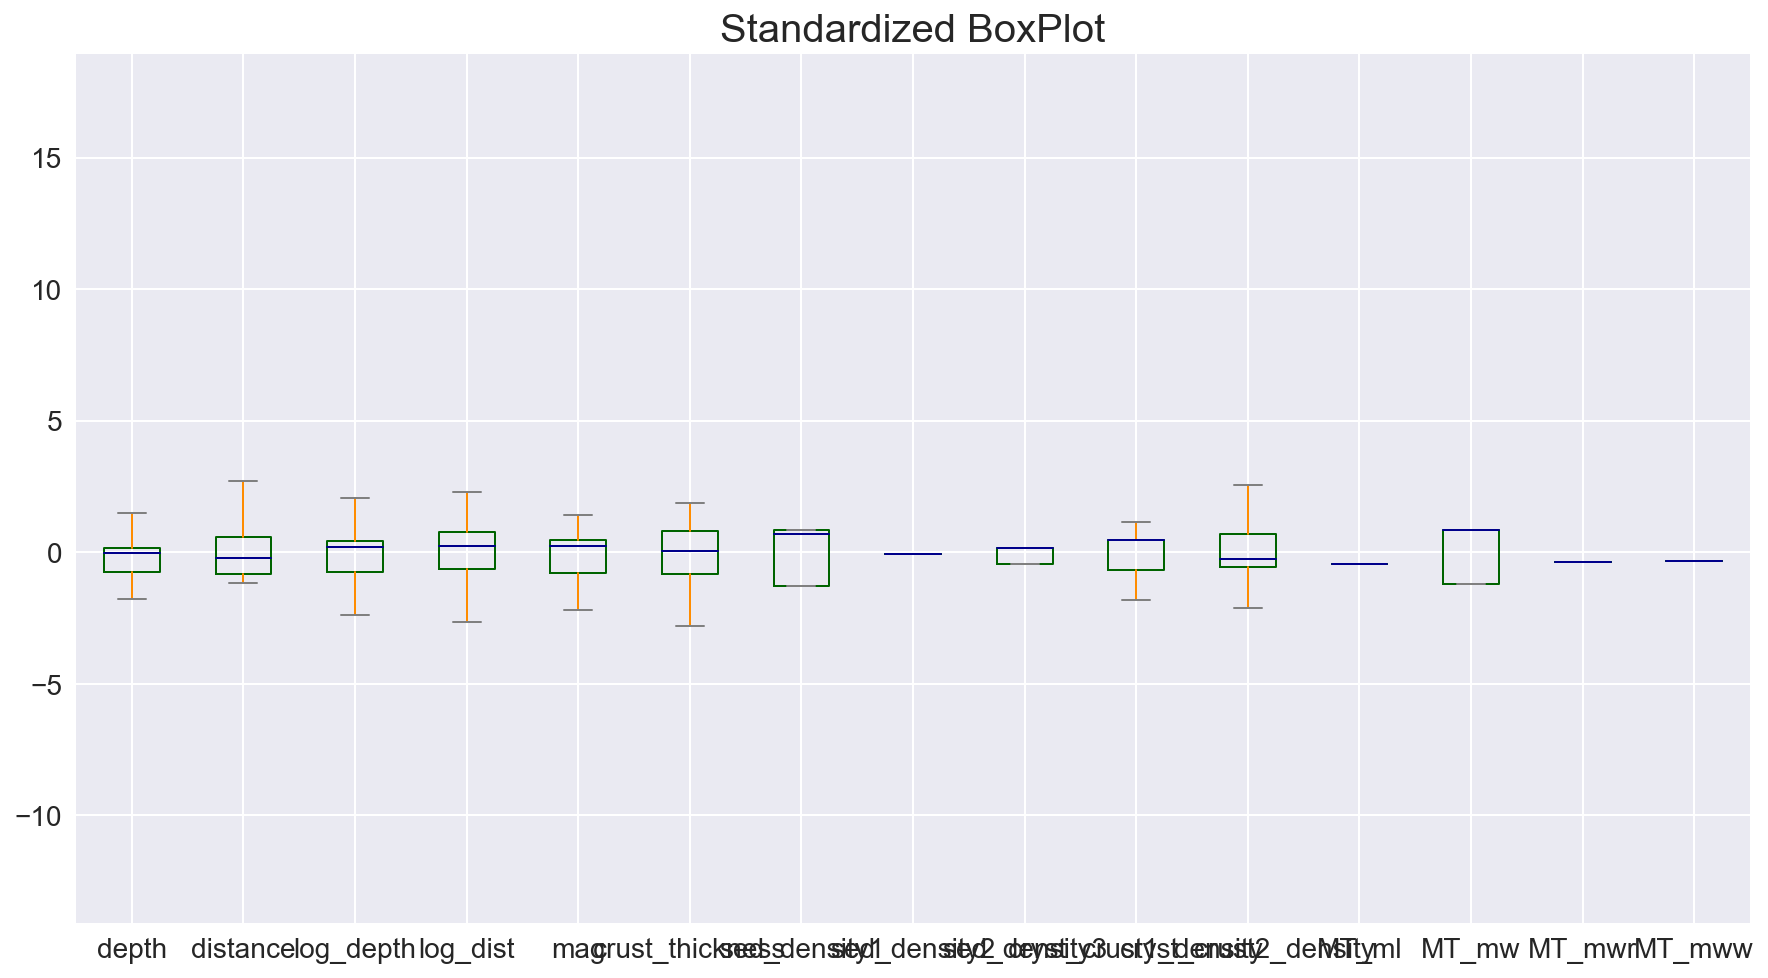

In [88]:
# Box plot vs. Scatter plot vs. Histogram.  While all of these give you a view of the spread of your data, the
#   - Box plot best at showing outliers if there are any
#   - Histogram gives the easiest and most intuitive look at the distribution
#   - Scatter plot is best at showing the correlation between two variables, and the "tightness" of that correlation

# The Rate should not be plotted on same box plot as the Math and Verbal because the scale, and also range, 
# are not the same, or even similar.

# Set colors, as this shows up better on the grey back ground
color = dict(boxes='DarkGreen', whiskers='DarkOrange', \
                medians='DarkBlue', caps='Gray')


ax = pd.DataFrame(Xstd_train, columns=factors)[factors].plot.box(color=color,\
                         figsize=(15,8), fontsize=14, \
                         title="Standardized BoxPlot")

#                          title="Standardized BoxPlot - " + ''.join([str(x) for x in factors]))
ax.title.set_size(20)


In [89]:
X_train.describe()   

,depth,distance,log_depth,log_dist,mag,crust_thickness,sed_density1,sed_density2,sed_density3,cryst_crust1_density,cryst_crust2_density,MT_ml,MT_mw,MT_mwr,MT_mww
count,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.00000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000
mean,10.228444,222.213072,0.950054,2.141242,5.418439,32.193936,1.473277,0.008317,2.73456,2.809037,3.337721,0.154630,0.590165,0.115278,0.090381
std,5.717231,187.185335,0.234039,0.489634,1.258777,8.034077,1.149106,0.145107,0.03402,0.043794,0.031972,0.361563,0.491818,0.319367,0.286736
min,0.010000,3.000000,-2.000000,0.477121,2.660000,9.800000,0.000000,0.000000,2.55000,2.730000,3.170000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,68.000000,0.778151,1.832509,4.450000,25.440000,0.000000,0.000000,2.72000,2.780000,3.320000,0.000000,0.000000,0.000000,0.000000
50%,9.987000,184.000000,0.999435,2.264818,5.700000,32.480000,2.280000,0.000000,2.74000,2.830000,3.330000,0.000000,1.000000,0.000000,0.000000
75%,11.120000,332.000000,1.046105,2.521138,6.020000,38.740000,2.460000,0.000000,2.74000,2.830000,3.360000,0.000000,1.000000,0.000000,0.000000
max,58.065000,1803.000000,1.763914,3.255996,7.200000,47.110000,2.460000,2.540000,2.79000,2.860000,3.420000,1.000000,1.000000,1.000000,1.000000


In [90]:
# Compute baseline

baseline = np.mean(y)
print baseline

3.16270212667


score: 0.466819432396
[-0.18359456 -0.09757017  0.09148835 -0.67063618  0.90415293  0.29755693
 -0.23024009 -0.01631084 -0.30893963  0.11873289  0.1550787  -0.02763923
  0.08354895  0.00365038  0.08004115]
3.15577932909
MSE:  0.350732048508
RMSE:  0.592226349049
Baseline: 3.16270212667
Baseline - MSE: 2.81197007817


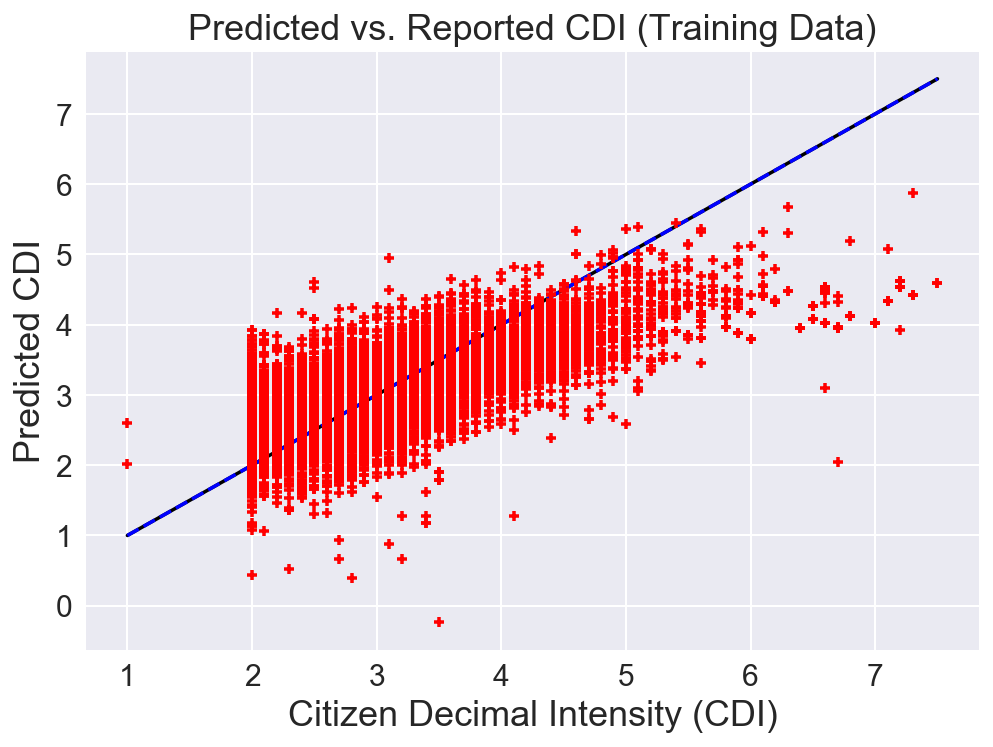

In [91]:
# Linear Regression Model

lm = linear_model.LinearRegression()

model = lm.fit(Xstd_train, y_train)

# Linear Regression with plot of predicted vs. actual y
predictions = model.predict(Xstd_train)
score = model.score(Xstd_train, y_train)
print "score:", score
print model.coef_
print model.intercept_

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

plt.scatter(y_train, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Predicted vs. Reported CDI (Training Data)', fontsize=18)

# I did this just to see how closely the training data was fit to itself.  When compared to the 
# predictions for test data, it will give a good indication if this model over fits

Score: 0.469723123165
MSE:  0.378967682222
RMSE:  0.615603510567
Baseline: 3.16270212667
Baseline - MSE: 2.78373444445


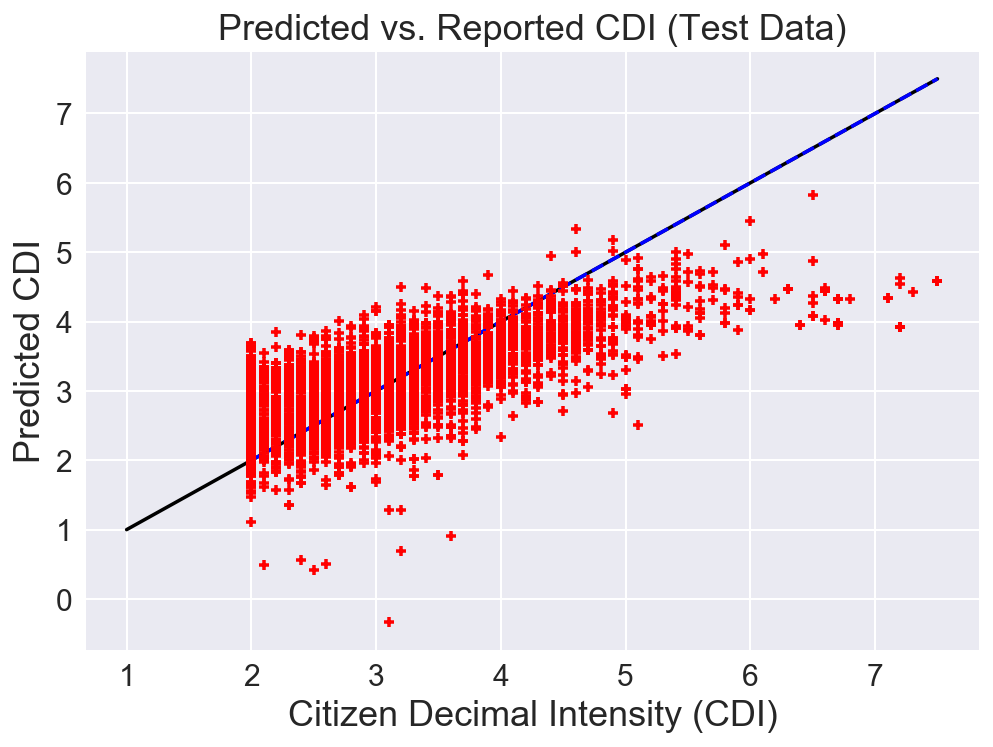

In [92]:
# Using the model above, now fit and plot against the test data
# Linear Regression with plot of predicted vs. actual y

predictions = model.predict(Xstd_test)
score = model.score(Xstd_test, y_test)
print "Score:", score

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

# pd.DataFrame(zip(all_sig_factors, model.coef_), columns=['factors', 'coefficients'])
# df_model_summary = pd.DataFrame([['LM', 'All Factors', len(factors), score, mse, rmse, baseline]], \
#                                 columns=['Model', 'Factors', '# Factors','Score', 'MSE', 'RMSE', 'Baseline'])

plt.scatter(y_test, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Predicted vs. Reported CDI (Test Data)', fontsize=18)

# T

In [93]:
m3_coef_df = pd.DataFrame({
        'features': X.columns,
        'coefficients': model.coef_,
    })
m3_coef_df.set_index('features', inplace=True)
m3_coef_df

,coefficients
features,
depth,-0.183595
distance,-0.097570
log_depth,0.091488
log_dist,-0.670636
mag,0.904153
crust_thickness,0.297557
sed_density1,-0.230240
sed_density2,-0.016311
sed_density3,-0.308940


In [94]:
# Scale the coefficients back to normal space
m3_coef_df['unscaled coeffs'] = m3_coef_df['coefficients']/ss.scale_
print "intercept:", 
m3_coef_df

intercept:

,coefficients,unscaled coeffs
features,,
depth,-0.183595,-0.032113
distance,-0.097570,-0.000521
log_depth,0.091488,0.390922
log_dist,-0.670636,-1.369710
mag,0.904153,0.718301
crust_thickness,0.297557,0.037038
sed_density1,-0.230240,-0.200371
sed_density2,-0.016311,-0.112409
sed_density3,-0.308940,-9.081274


In [95]:
def USGS_West(mag, dist):
    return 1.01 * mag - 0.00054 * dist - 1.72 * np.log10(dist) + 1.15

def USGS_East(mag, dist):
    return 1.29 * mag - 0.00051 * dist - 2.16 * np.log10(dist) + 1.60

def Schroyer_OK(mag, dist):
    return 0.93 * mag - 1.15 * np.log10(dist) + 1.14

def USGS_West_CDI(mag, dist):
    c1 = 12.27
    c2 = 2.770
    c3 = 0.1304
    c4 = -1.30
    c5 = -0.0007070
    c6 = 1.95
    c7 = -0.577
    h = 14.0
    Rt = 30.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)

def USGS_East_CDI(mag, dist):
    c1 = 11.72
    c2 = 2.36
    c3 = 0.1155
    c4 = -0.44
    c5 = -0.002044
    c6 = 2.31
    c7 = -0.479
    h = 17.0
    Rt = 80.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)


def mmi_model(mag, dist, depth):
    return  0.716 * mag \
            - 0.000499 * dist \
            - 1.392 * np.log10(dist) \
            - 0.032600 * depth \
            + 0.447651 * np.log10(depth) \
            + 2.74    # From unstandardized model

# Unstandardized coefficients
# [ -2.89265667e-02  -4.17982242e-04   3.66942791e-01  -1.42012668e+00
#    7.14302483e-01   3.61019940e-02  -2.01460399e-01  -1.27566077e-01
#   -8.91798382e+00   2.32909940e+00   4.93908894e+00  -8.37253674e-02
#    1.79412033e-01   3.32932796e-02   3.18597500e-01]
# 2.74072204788

# Standardized coefficients
# depth	-0.186197	-0.032600
# distance	-0.092787	-0.000499
# log_depth	0.102015	0.447651
# log_dist	-0.681868	-1.392475
# mag	0.901963	0.715881
# crust_thickness	0.297674	0.036927
# sed_density1	-0.230187	-0.200541
# sed_density2	-0.012200	-0.089264
# sed_density3	-0.303361	-8.956431
# cryst_crust1_density	0.106088	2.433927
# cryst_crust2_density	0.154045	4.820320
# MT_ml	-0.036028	-0.099550
# MT_mw	0.081290	0.165088
# MT_mwr	0.006441	0.019863
# MT_mww	0.086942	0.304632
 

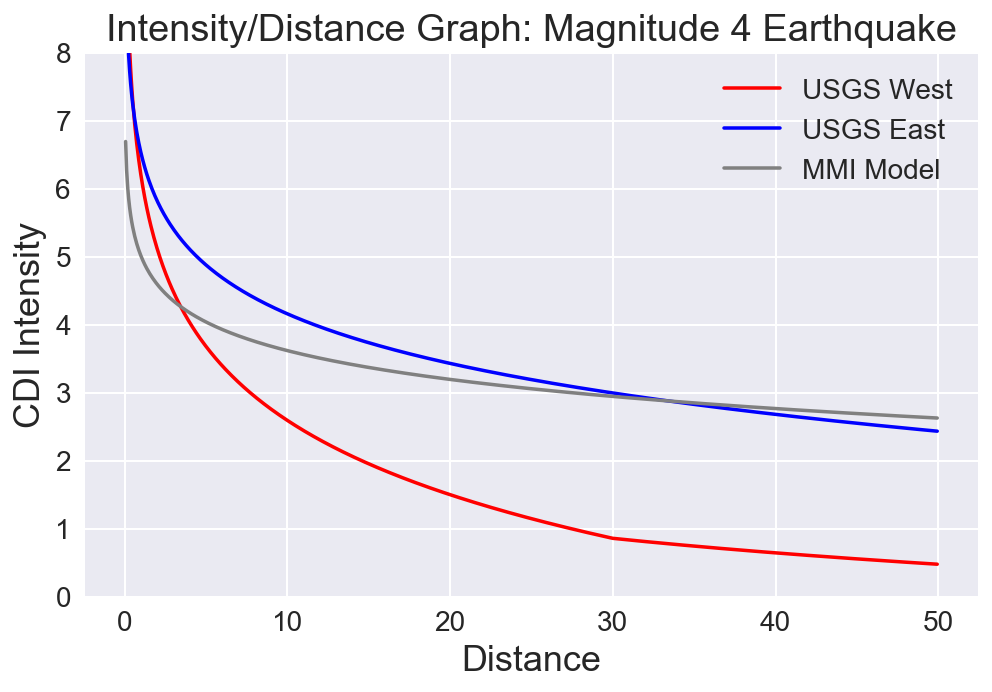

In [96]:
# Generate Distance values
dist = np.arange(0.1, 50*1.61, 0.1)
depth = 40
mag = 4

WI = []
EI = []
MM = []
for i in range(len(dist)):
    WI.append(USGS_West_CDI(mag, dist[i]/1.61))
    EI.append(USGS_East_CDI(mag, dist[i]/1.61))
    MM.append(mmi_model(mag, dist[i]/1.61, depth))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dist/1.61, WI, label='USGS West', color='r') 
ax.plot(dist/1.61, EI, label='USGS East', color='b')
ax.plot(dist/1.61, MM, label='MMI Model', color='grey')
x1,x2,y1,y2  = ax.axis()
ax.axis((x1,x2,0,8))
plt.xlabel('Distance', fontsize=18)
plt.ylabel('CDI Intensity', fontsize=18)
plt.tick_params(labelsize=14)
title_string = 'Intensity/Distance Graph: Magnitude ' + str(mag) + ' Earthquake'
plt.title(title_string, fontsize=19)
ax.legend(fontsize=14)

plt.show()

### Set up for GridSearch, determine if the model can be further improved.

In [331]:
from sklearn.linear_model import ElasticNetCV

# Use ElasticNet regularization and find optimall values
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=3,
                            verbose=1)
optimal_enet.fit(Xstd_train, y_train)

print "Optimal alpha:", optimal_enet.alpha_
print "Optimal l1 ratio:", optimal_enet.l1_ratio_
print 
print "Optimal Intercept:", optimal_enet.intercept_
optimal_coeffs = pd.DataFrame(optimal_enet.coef_)
optimal_coeffs



........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal alpha: 0.000318294936976
Optimal l1 ratio: 1.0

Optimal Intercept: 3.16520664731


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.3s finished


,0
0,-0.176662
1,-0.092633
2,0.094231
3,-0.679663
4,0.896901
5,0.294181
6,-0.228566
7,-0.012205
8,-0.297144
9,0.099276


score: 0.470750069828
MSE:  0.356639460891
RMSE:  0.59719298463
Baseline: 3.16270212667
Baseline - MSE: 2.80606266578


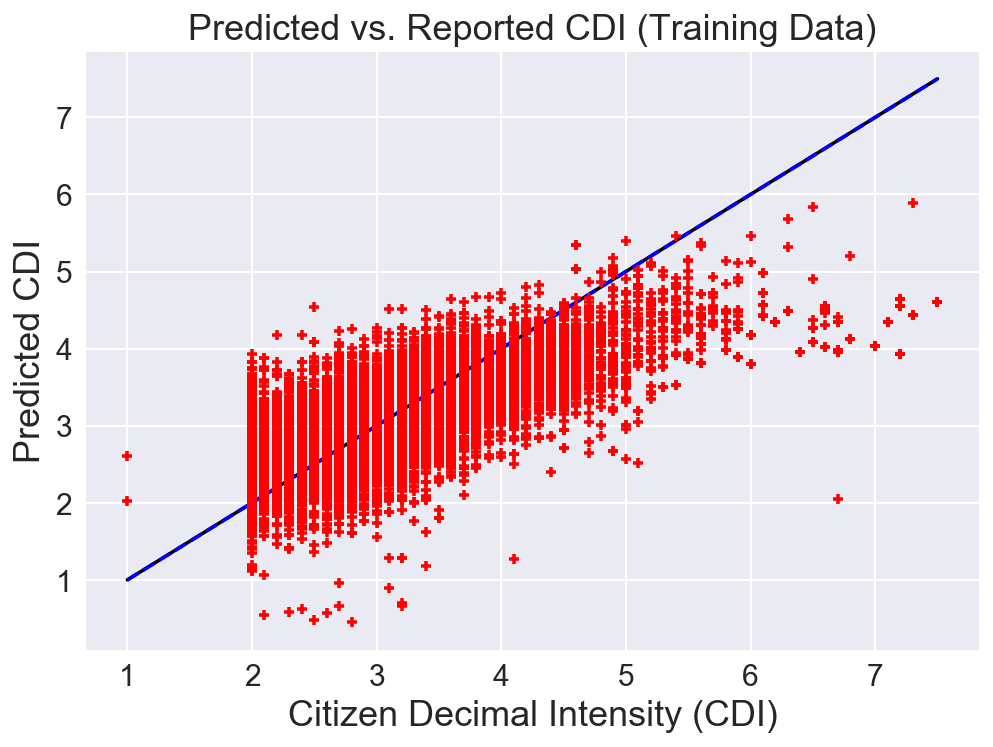

In [332]:
# Linear Regression with plot of predicted vs. actual y
predictions = optimal_enet.predict(Xstd_train)
score = optimal_enet.score(Xstd_train, y_train)
print "score:", score

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

plt.scatter(y_train, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Predicted vs. Reported CDI (Training Data)', fontsize=18)


score: 0.45865902027
MSE:  0.361085740563
RMSE:  0.600904102635
Baseline: 3.16270212667
Baseline - MSE: 2.80161638611


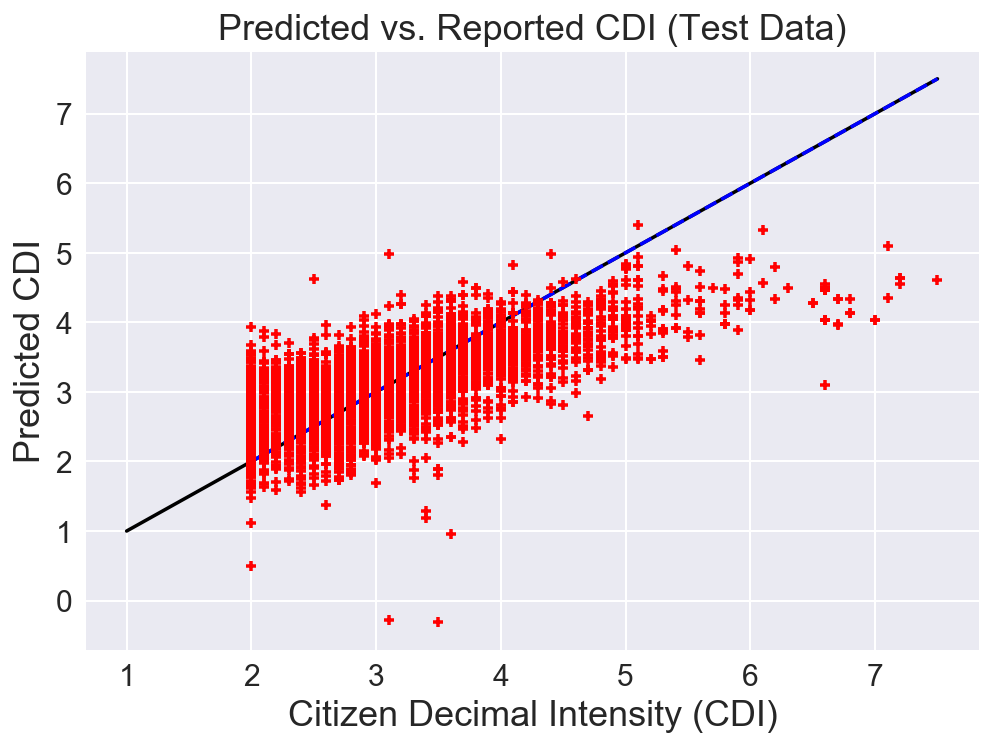

In [333]:
# Linear Regression with plot of predicted vs. actual y
predictions = optimal_enet.predict(Xstd_test)
score = optimal_enet.score(Xstd_test, y_test)
print "score:", score

# Calculate the RMSE of model using sklearn.metrics.mean_squared_error.
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print "MSE: ", mse
print "RMSE: ", rmse
print "Baseline:", baseline
print "Baseline - MSE:", baseline - mse

# pd.DataFrame(zip(all_sig_factors, model.coef_), columns=['factors', 'coefficients'])
# df_model_summary = pd.DataFrame([['LM', 'All Factors', len(factors), score, mse, rmse, baseline]], \
#                                 columns=['Model', 'Factors', '# Factors','Score', 'MSE', 'RMSE', 'Baseline'])

plt.scatter(y_test, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k')
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k', linestyle='dashed', color="b")
plt.xlabel('Citizen Decimal Intensity (CDI)', fontsize=18)
plt.ylabel('Predicted CDI', fontsize=18)
plt.title('Predicted vs. Reported CDI (Test Data)', fontsize=18)


In [334]:
m4_coef_df = pd.DataFrame({
        'features': X.columns,
        'coefficients': optimal_enet.coef_,
    })
m4_coef_df.set_index('features', inplace=True)
m4_coef_df

,coefficients
features,
depth,-0.176662
distance,-0.092633
log_depth,0.094231
log_dist,-0.679663
mag,0.896901
crust_thickness,0.294181
sed_density1,-0.228566
sed_density2,-0.012205
sed_density3,-0.297144


In [335]:
ss.scale_

array([  5.71149224e+00,   1.86044705e+02,   2.27889887e-01,
         4.89680350e-01,   1.25993500e+00,   8.06106606e+00,
         1.14783033e+00,   1.36668379e-01,   3.38707904e-02,
         4.35871775e-02,   3.19575154e-02,   3.61905567e-01,
         4.92403022e-01,   3.24278337e-01,   2.85398656e-01])

In [336]:
# Scale the coefficients back to normal space
m4_coef_df['unscaled coeffs'] = m4_coef_df['coefficients']/ss.scale_
print "intercept:", 
m4_coef_df

intercept:

,coefficients,unscaled coeffs
features,,
depth,-0.176662,-0.030931
distance,-0.092633,-0.000498
log_depth,0.094231,0.413494
log_dist,-0.679663,-1.387973
mag,0.896901,0.711863
crust_thickness,0.294181,0.036494
sed_density1,-0.228566,-0.199129
sed_density2,-0.012205,-0.089302
sed_density3,-0.297144,-8.772868


In [337]:
m4_coef_df.sort_values(by='coefficients', ascending=0)

,coefficients,unscaled coeffs
features,,
mag,0.896901,0.711863
crust_thickness,0.294181,0.036494
cryst_crust2_density,0.155240,4.857697
cryst_crust1_density,0.099276,2.277638
log_depth,0.094231,0.413494
MT_mww,0.086904,0.304501
MT_mw,0.079687,0.161833
MT_mwr,0.005708,0.017603
sed_density2,-0.012205,-0.089302


In [338]:
# Create a subset of "coef_df" DataFrame with most important coefficients
imp_coefs = pd.concat([m4_coef_df.sort_values(by='coefficients', ascending=0).head(3),\
                      m4_coef_df.sort_values(by='coefficients', ascending=0).tail(4)])

In [339]:

imp_coefs

,coefficients,unscaled coeffs
features,,
mag,0.896901,0.711863
crust_thickness,0.294181,0.036494
cryst_crust2_density,0.155240,4.857697
depth,-0.176662,-0.030931
sed_density1,-0.228566,-0.199129
sed_density3,-0.297144,-8.772868
log_dist,-0.679663,-1.387973


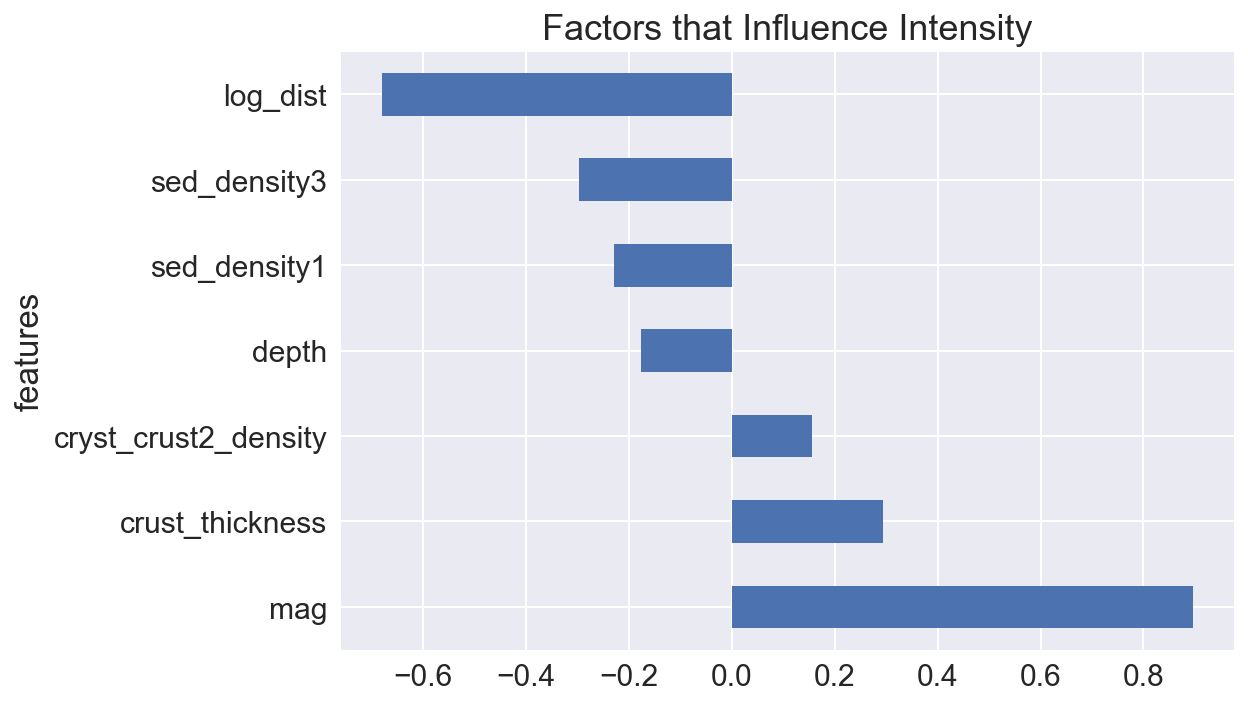

In [340]:
# Plot important coefficients
sns.set(font_scale=1.5)
imp_coefs['coefficients'].plot(kind = "barh")
# plt.title("Coefficient importance with Ridge regularization")
plt.title("Factors that Influence Intensity")
plt.show()

In [305]:
def USGS_West(mag, dist):
    return 1.01 * mag - 0.00054 * dist - 1.72 * np.log10(dist) + 1.15

def USGS_East(mag, dist):
    return 1.29 * mag - 0.00051 * dist - 2.16 * np.log10(dist) + 1.60

def Schroyer_OK(mag, dist):
    return 0.93 * mag - 1.15 * np.log10(dist) + 1.14

def USGS_West_CDI(mag, dist):
    c1 = 12.27
    c2 = 2.770
    c3 = 0.1304
    c4 = -1.30
    c5 = -0.0007070
    c6 = 1.95
    c7 = -0.577
    h = 14.0
    Rt = 30.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)

def USGS_East_CDI(mag, dist):
    c1 = 11.72
    c2 = 2.36
    c3 = 0.1155
    c4 = -0.44
    c5 = -0.002044
    c6 = 2.31
    c7 = -0.479
    h = 17.0
    Rt = 80.0
    if dist <= Rt:
        B = 0
    else:
        B = np.log10(dist/Rt)
    return c1 + c2*(mag-6) -c3*(mag-6)**2 + c4*np.log10(dist) + c5*dist + c6*B + c7*mag*np.log10(dist)


def mmi_model(mag, dist, depth, crthick, s1dens, s2dens, s3dens, c1dens, c2dens, c3dens):
    return  0.556 * mag \
            - 0.704 * np.log10(dist) \
            - 0.021 * depth \
            + 0.03641 * crthick \
            - 0.185 * s3dens \
            + 0.999    # From unstandardized regression (not elasticnet) model

#             + 5.082 * c2dens \


# Unstandardized coefficients
# mag	0.556225
# crust_thickness	0.041387
# MT_mw	0.007726
# distance	-0.000848
# depth	-0.021300
# sed_density1	-0.185493
# log_dist	-0.703688

# Standardized coefficients    
# mag	0.896901	0.711863
# crust_thickness	0.294181	0.036494
# cryst_crust2_density	0.155240	4.857697
# depth	-0.176662	-0.030931
# sed_density1	-0.228566	-0.199129
# sed_density3	-0.297144	-8.772868
# log_dist	-0.679663	-1.387973    

40 46.98 2.46 0.0 2.74 2.83 2.92 3.37


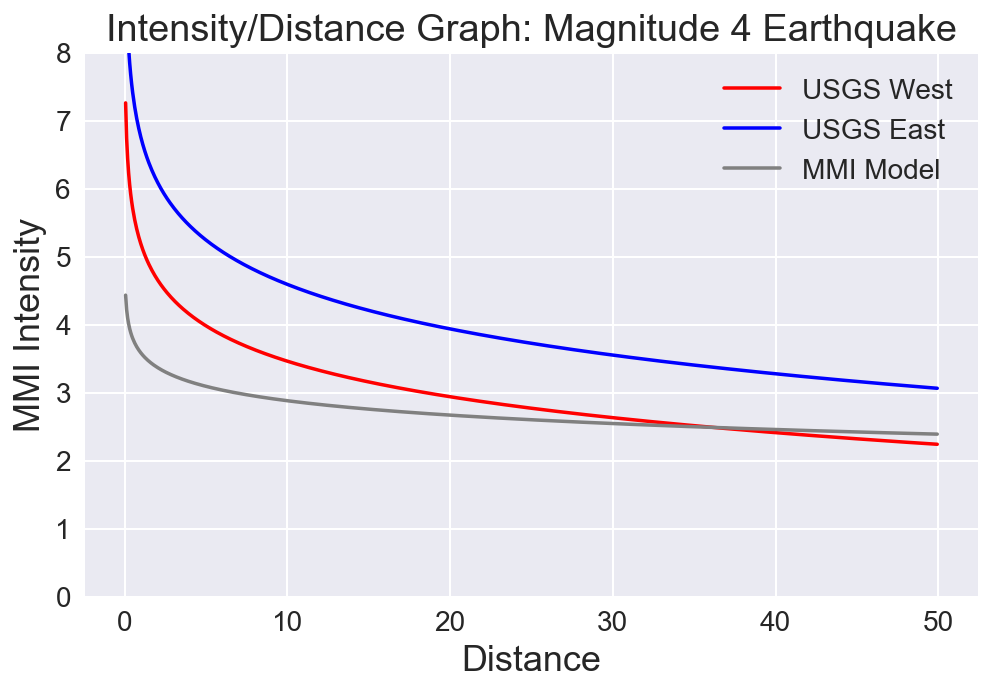

In [306]:
# Generate Distance values
dist = np.arange(0.1, 50*1.61, 0.1)
depth = 40
mag = 4
clat = 35.47
clon = -97.52
crthick = np.abs(get_crust(clat, clon, 'bnds')[-1])
s1dens = get_crust(clat, clon, 'rho')[6]
s2dens = get_crust(clat, clon, 'rho')[7]
s3dens = get_crust(clat, clon, 'rho')[8]
c1dens = get_crust(clat, clon, 'rho')[9]
c2dens = get_crust(clat, clon, 'rho')[10]
c3dens = get_crust(clat, clon, 'rho')[11]

print depth, crthick, s1dens, s2dens, s3dens, c1dens, c2dens, c3dens

WI = []
EI = []
MM = []
for i in range(len(dist)):
    WI.append(USGS_West(mag, dist[i]/1.61))
    EI.append(USGS_East(mag, dist[i]/1.61))
    MM.append(mmi_model(mag, dist[i]/1.61, depth, crthick, s1dens, s1dens, s3dens, c1dens, c2dens, c3dens))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dist/1.61, WI, label='USGS West', color='r') 
ax.plot(dist/1.61, EI, label='USGS East', color='b')
ax.plot(dist/1.61, MM, label='MMI Model', color='grey')
x1,x2,y1,y2  = ax.axis()
ax.axis((x1,x2,0,8))
plt.xlabel('Distance', fontsize=18)
plt.ylabel('MMI Intensity', fontsize=18)
plt.tick_params(labelsize=14)
title_string = 'Intensity/Distance Graph: Magnitude ' + str(mag) + ' Earthquake'
plt.title(title_string, fontsize=19)
ax.legend(fontsize=14)

plt.show()

### Set up for GridSearch, determine if the model can be further improved.